# DTSA-5510 Final Project
# Examining COVID-19 Outcomes with Unsupervised Learning

## Dataset: 
Synthetic COVID-19 patient records, available at https://synthea.mitre.org/downloads
## Problem
Can COVID-19 outcomes (survival/ICU admission/ventilation) be predicted from electronic health records (EHR) data for patients hospitalized for the disease?
* Unsupervised learning problem: Given unlabeled EHR data, can an unsupervised algorithm cluster patients by outcome? 
* Since the data does actually have labels, we can compare it to a supervised learning algorithm(s)

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import itertools

In [2]:
conditions = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")
patients = pd.read_csv("10k_synthea_covid19_csv/patients.csv")
observations = pd.read_csv("10k_synthea_covid19_csv/observations.csv")
care_plans = pd.read_csv("10k_synthea_covid19_csv/careplans.csv")
encounters = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")
# devices = pd.read_csv("10k_synthea_covid19_csv/devices.csv")
# supplies = pd.read_csv('10k_synthea_covid19_csv/supplies.csv')
procedures = pd.read_csv("10k_synthea_covid19_csv/procedures.csv")
# medications = pd.read_csv("10k_synthea_covid19_csv/medications.csv")
# encounters.head()
# observations.head()
# conditions.DESCRIPTION.unique()
# patients

In [3]:
# Patients diagnosed with COVID-19
covid_patient_ids = conditions[conditions.CODE == 840539006].PATIENT.unique()
print(f"Total number of patients: {patients.shape[0]}")
print(f"Number of patients diagnosed with COVID-19: {len(covid_patient_ids)}")

# Patients with negative COVID test
negative_covid_patient_ids = observations[(observations.CODE == '94531-1') & (observations.VALUE == 'Not detected (qualifier value)')].PATIENT.unique()
print(f"Number of patients who tested negative: {len(negative_covid_patient_ids)}")

# All deceased patients (not just COVID-19)
deceased_patients = patients[patients.DEATHDATE.notna()].Id

# Patients who completed isolation at home
completed_isolation_patients = care_plans[(care_plans.CODE == 736376001) & (care_plans.STOP.notna()) & (care_plans.REASONCODE == 840539006)].PATIENT

# Survivors
survivor_ids = np.union1d(completed_isolation_patients, negative_covid_patient_ids)
print(f"Total number of survivors: {len(survivor_ids)}")

# COVID admissions
inpatient_ids = encounters[(encounters.REASONCODE == 840539006) & (encounters.CODE == 1505002)].PATIENT
print(f"Total number of COVID admissions: {len(inpatient_ids)}")

# Inpatient survivorship
print(f"Number of inpatient survivors: {np.intersect1d(inpatient_ids, survivor_ids).shape[0]}")
print(f"Number of inpatient non-survivors: {np.intersect1d(inpatient_ids, deceased_patients).shape[0]}")

Total number of patients: 12352
Number of patients diagnosed with COVID-19: 8820
Number of patients who tested negative: 1808
Total number of survivors: 8759
Total number of COVID admissions: 1867
Number of inpatient survivors: 1522
Number of inpatient non-survivors: 349


In [4]:
unique_obs = observations.DESCRIPTION.unique()
print(f"Number of observations: {len(unique_obs)}")
unique_conds = conditions.DESCRIPTION.unique()
print(f"Number of conditions: {len(unique_conds)}")

Number of observations: 201
Number of conditions: 180


In [5]:
# Select COVID-19 conditions out of all conditions in the simulation
covid_conditions = conditions[conditions.CODE == 840539006]

# Merge the COVID-19 conditions with the patients
covid_patients = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')

#Add an attribute to the DataFrame indicating whether this is a survivor or not.
covid_patients['survivor'] = covid_patients.PATIENT.isin(survivor_ids)
covid_patients = covid_patients[['START', 'PATIENT', 'survivor', 'CODE']]

Calculate attributes based on day with 0 being date of admission. 

In [6]:
covid_patients_obs = covid_patients.merge(observations, on='PATIENT')
covid_patients_obs['START'] = pd.to_datetime(covid_patients_obs.START)
covid_patients_obs['DATE'] = pd.to_datetime(covid_patients_obs.DATE)
covid_patients_obs['lab_days'] = covid_patients_obs.DATE - covid_patients_obs.START
covid_patients_obs['days'] = covid_patients_obs.lab_days / np.timedelta64(1, 'D')
# covid_patients_obs['VALUE'] = pd.to_numeric(covid_patients_obs['VALUE'], errors='coerce')
covid_patients_obs.head(5)

,START,PATIENT,survivor,CODE_x,DATE,ENCOUNTER,CODE_y,DESCRIPTION,VALUE,UNITS,TYPE,lab_days,days
0,2020-03-01,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,True,840539006,2019-08-01,6a74fdef-2287-44bf-b9e7-18012376faca,8302-2,Body Height,82.7,cm,numeric,-213 days,-213.0
1,2020-03-01,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,True,840539006,2019-08-01,6a74fdef-2287-44bf-b9e7-18012376faca,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,2.0,{score},numeric,-213 days,-213.0
2,2020-03-01,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,True,840539006,2019-08-01,6a74fdef-2287-44bf-b9e7-18012376faca,29463-7,Body Weight,12.6,kg,numeric,-213 days,-213.0
3,2020-03-01,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,True,840539006,2019-08-01,6a74fdef-2287-44bf-b9e7-18012376faca,77606-2,Weight-for-length Per age and sex,86.1,%,numeric,-213 days,-213.0
4,2020-03-01,f0f3bc8d-ef38-49ce-a2bd-dfdda982b271,True,840539006,2019-08-01,6a74fdef-2287-44bf-b9e7-18012376faca,9843-4,Head Occipital-frontal circumference,46.9,cm,numeric,-213 days,-213.0


In [7]:
icu_ids = encounters[encounters.CODE == 305351004].PATIENT.unique()
vent_ids = procedures[procedures.CODE == 26763009].PATIENT.unique()

Convert EHR list into dataframe

In [8]:
class Patient:
    def __init__(self, ID):
        self.ID = ID
        self.observations = covid_patients_obs[covid_patients_obs.PATIENT == self.ID].copy()
        self.conditions = conditions[conditions.PATIENT == self.ID].copy()
    
    def convert_obs_conds(self):
        df1 = pd.DataFrame(columns = unique_obs, index=[0])

        for index, row in self.observations[self.observations.days <= 1].iterrows():
            df1[row['DESCRIPTION']] = row['VALUE']
        df2 = pd.DataFrame(np.zeros((1, len(unique_conds))), columns = unique_conds)
        for row in self.conditions.DESCRIPTION:
            df2[row] = 1
        df2["Survived"] = self.ID in survivor_ids
        df2["ICU"] = self.ID in icu_ids
        df2["Ventilated"] = self.ID in vent_ids
        return df1.join(df2)


# why does this take so long to run?
zero_day_observations = None
for i, patient in enumerate(inpatient_ids[:]):
    pt = Patient(patient)
    new_row_df = pt.convert_obs_conds()
    if zero_day_observations is None:
        zero_day_observations = new_row_df.copy()
    else:
        zero_day_observations = pd.concat((zero_day_observations, new_row_df), axis=0)
zero_day_observations.head()

,Body Height,Pain severity - 0-10 verbal numeric rating [Score] - Reported,Body Weight,Weight-for-length Per age and sex,Head Occipital-frontal circumference,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate,Tobacco smoking status NHIS,...,Cystic Fibrosis,Diabetes from Cystic Fibrosis,Blindness due to type 2 diabetes mellitus (disorder),History of disarticulation at wrist (situation),Male Infertility,Acute Cholecystitis,Cholelithiasis,Survived,ICU,Ventilated
0,67.1,4.0,8.3,79.6,42.8,72.0,129.0,193.7,34.4,Never smoker,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False
0,162.5,3.0,74.6,NaN,NaN,82.0,124.0,107.3,26.7,Never smoker,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False
0,158.1,2.0,76.5,NaN,NaN,83.0,122.0,58.3,32.0,Former smoker,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False
0,NaN,NaN,85.9,NaN,NaN,73.0,116.0,140.1,16.4,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False
0,170.8,4.0,87.7,NaN,NaN,78.0,113.0,86.9,39.1,Never smoker,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,False,False


There are a lot of NaNs, so let's drop any column with 70% NaNs. Then let's set data types to numeric, otherwise category. Then set category to category codes so that it is a number that can be used by machine learning. 

In [9]:
observations_df = zero_day_observations.copy()
observations_df = observations_df.dropna(axis=1, thresh=0.7*len(observations_df))
for col, dtype in zip(observations_df.columns, observations_df.dtypes):
    observations_df[col] = pd.to_numeric(observations_df[col], errors="ignore")
for col, dtype in zip(observations_df.columns, observations_df.dtypes):
    if dtype == 'object':
        observations_df[col] = observations_df[col].astype('category')
for col, dtype in zip(observations_df.columns, observations_df.dtypes):
    if dtype.name == 'category':
        observations_df[col] = observations_df[col].cat.codes
observations_df.describe()

,Body Height,Pain severity - 0-10 verbal numeric rating [Score] - Reported,Body Weight,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate,Tobacco smoking status NHIS,Body Mass Index,Body temperature,...,Tear of meniscus of knee,Posttraumatic stress disorder,Female Infertility,Cystic Fibrosis,Diabetes from Cystic Fibrosis,Blindness due to type 2 diabetes mellitus (disorder),History of disarticulation at wrist (situation),Male Infertility,Acute Cholecystitis,Cholelithiasis
count,1411.000000,1417.000000,1867.000000,1867.000000,1867.000000,1867.000000,1867.000000,1867.000000,1398.000000,1867.000000,...,1867.000000,1867.000000,1867.0,1867.0,1867.0,1867.0,1867.000000,1867.0,1867.000000,1867.000000
mean,167.024380,2.064926,79.642046,80.824853,121.605785,125.552330,26.034494,1.010712,28.008083,39.898768,...,0.000536,0.000536,0.0,0.0,0.0,0.0,0.000536,0.0,0.000536,0.000536
std,15.823667,1.346167,16.118628,7.500687,14.259009,43.055072,8.181541,1.216576,3.489438,1.285455,...,0.023143,0.023143,0.0,0.0,0.0,0.0,0.023143,0.0,0.023143,0.023143
min,50.100000,0.000000,4.100000,68.000000,99.000000,50.100000,12.100000,-1.000000,13.200000,37.100000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
25%,161.900000,1.000000,72.800000,76.000000,112.000000,88.850000,18.950000,1.000000,27.500000,38.800000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
50%,168.000000,2.000000,80.500000,80.000000,120.000000,126.000000,26.100000,2.000000,28.100000,39.900000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
75%,176.100000,3.000000,89.250000,84.000000,128.000000,162.400000,33.100000,2.000000,29.900000,41.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
max,198.700000,10.000000,149.100000,121.000000,198.000000,199.900000,40.000000,2.000000,49.600000,42.200000,...,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,1.000000,1.000000


# EDA
Let's take a took at the distribution for each feature

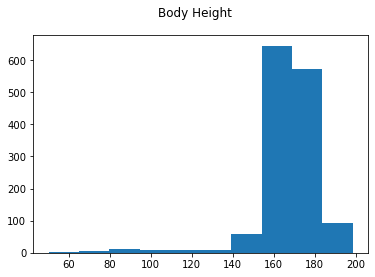

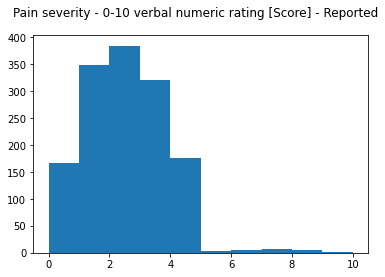

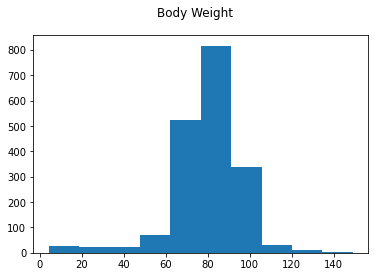

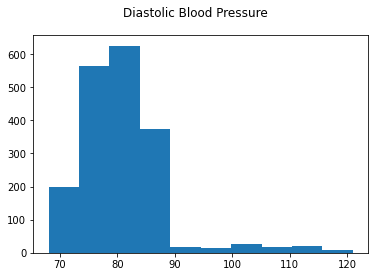

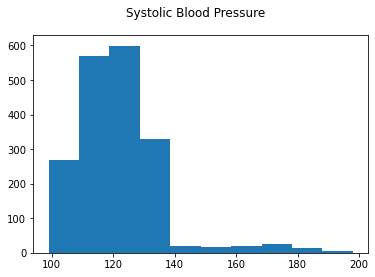

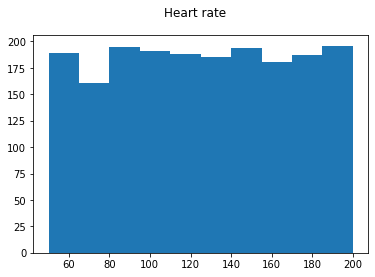

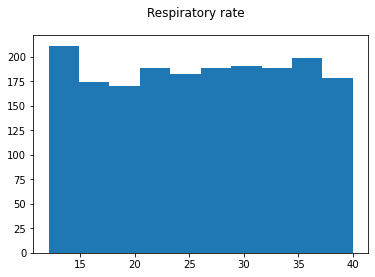

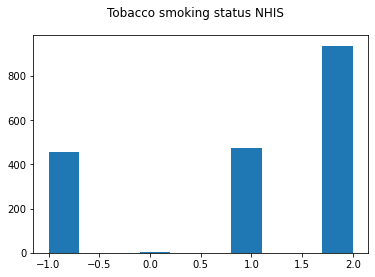

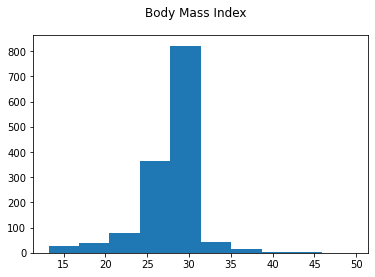

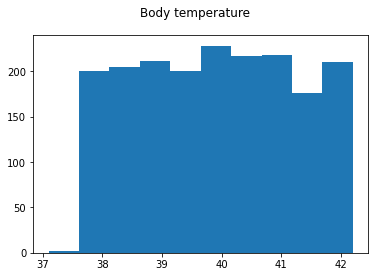

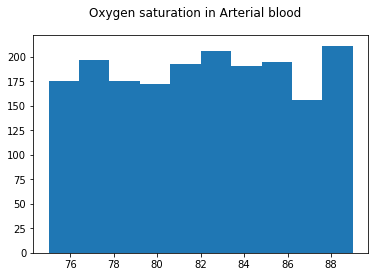

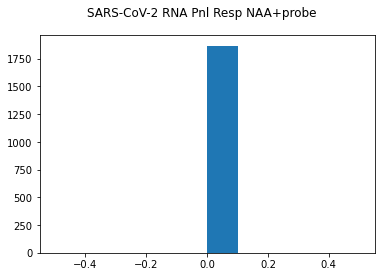

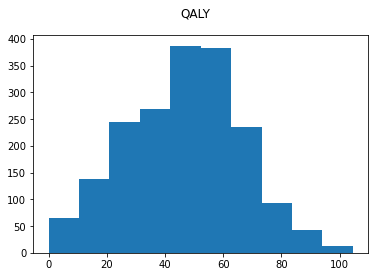

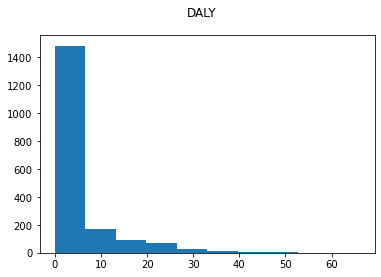

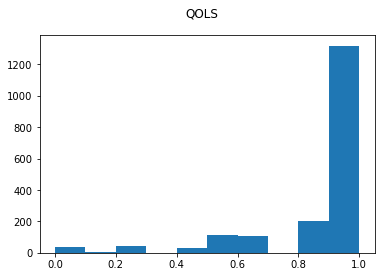

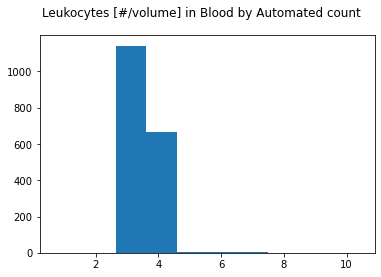

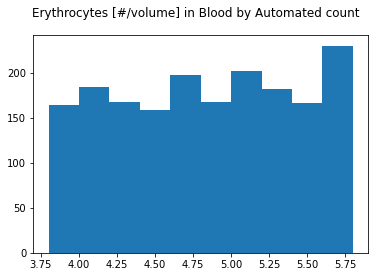

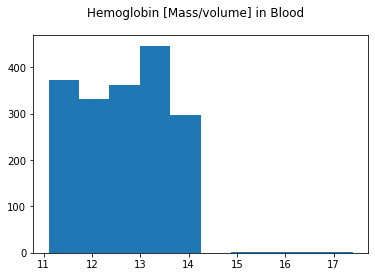

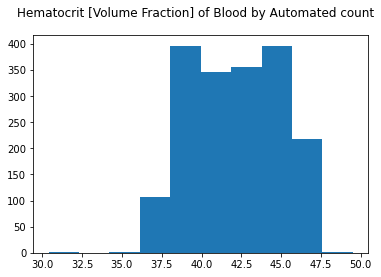

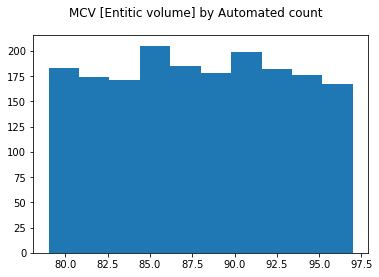

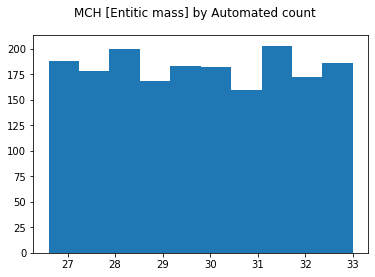

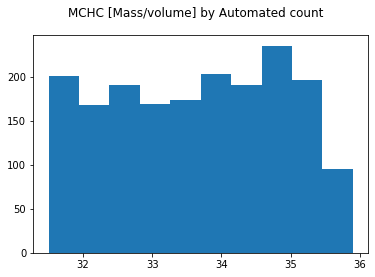

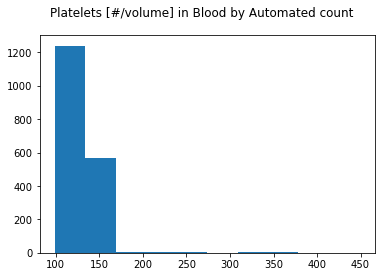

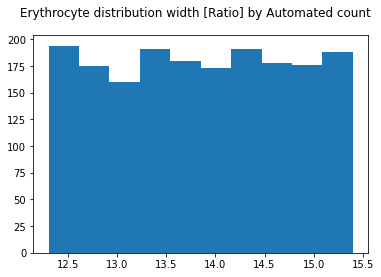

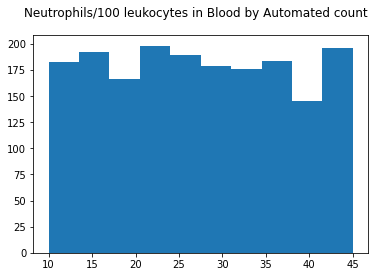

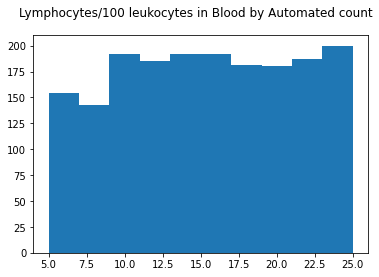

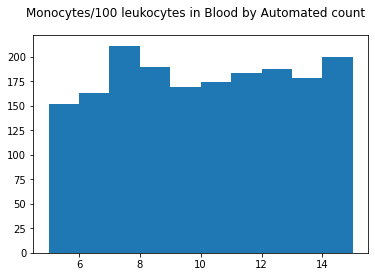

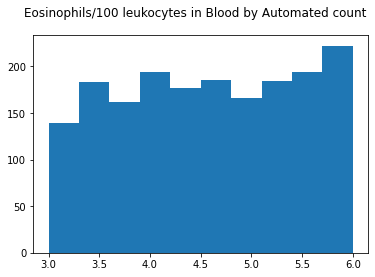

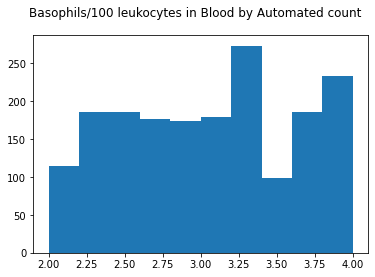

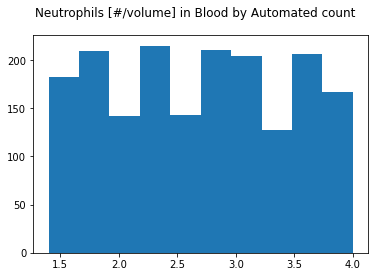

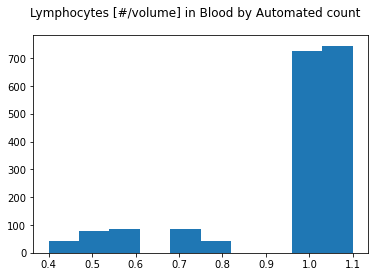

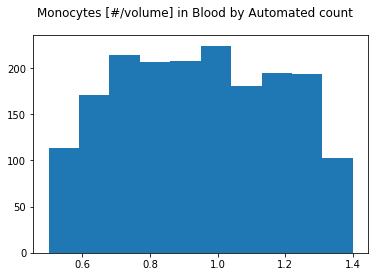

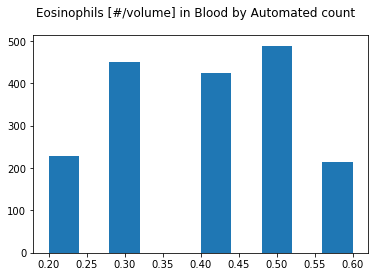

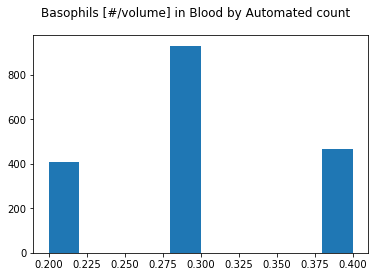

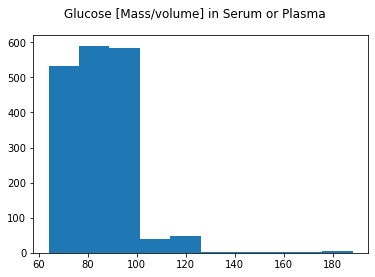

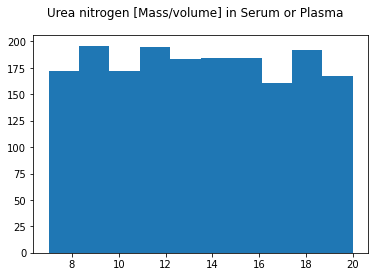

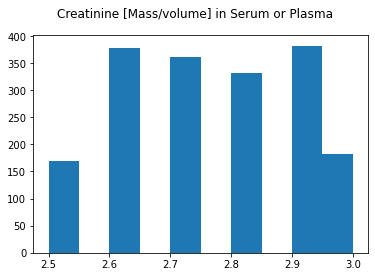

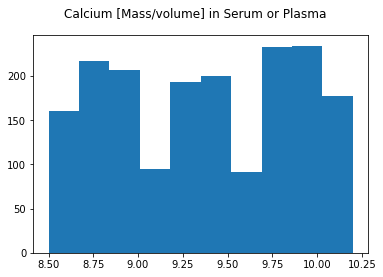

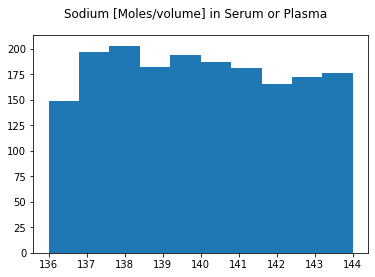

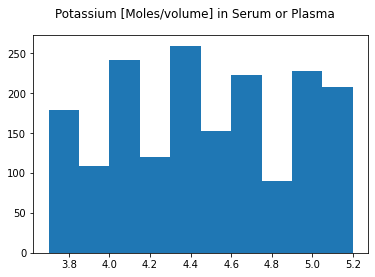

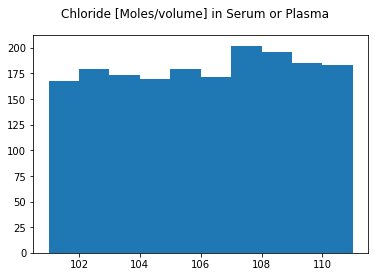

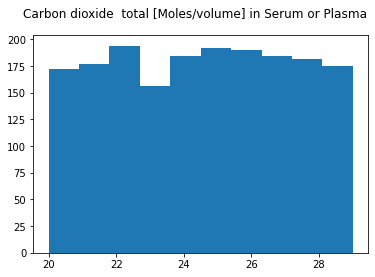

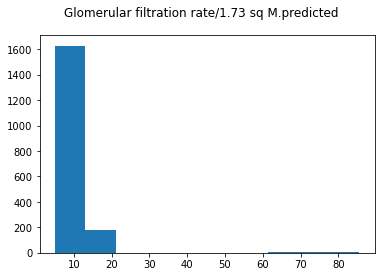

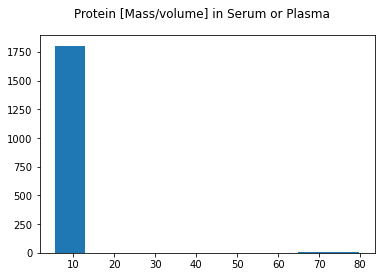

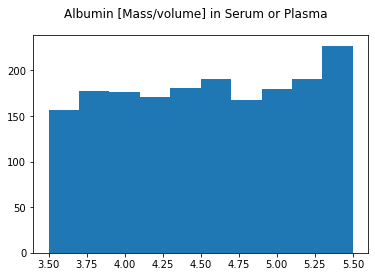

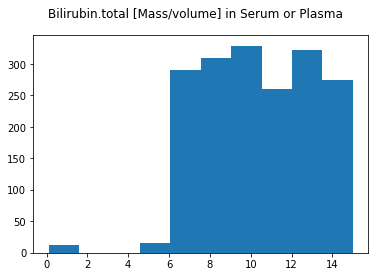

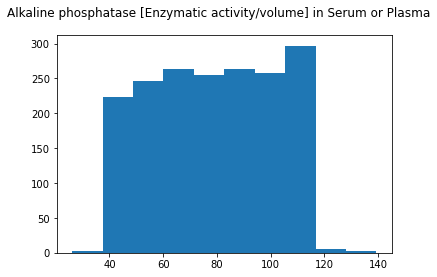

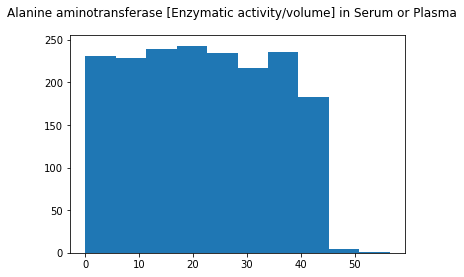

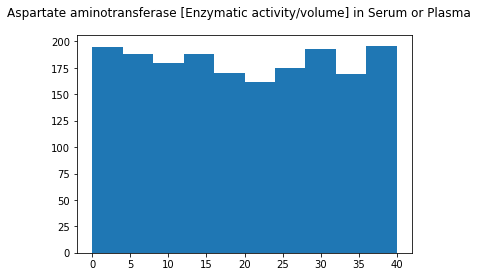

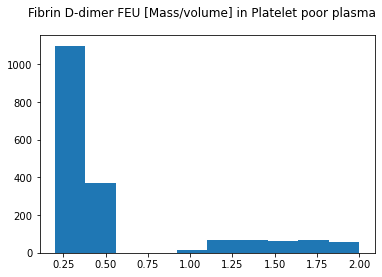

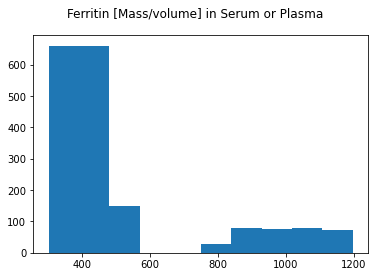

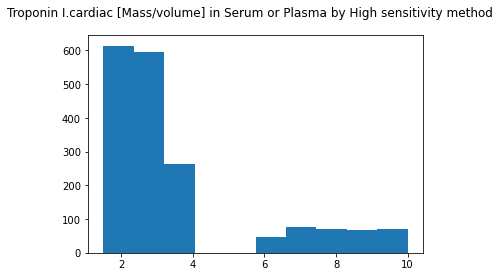

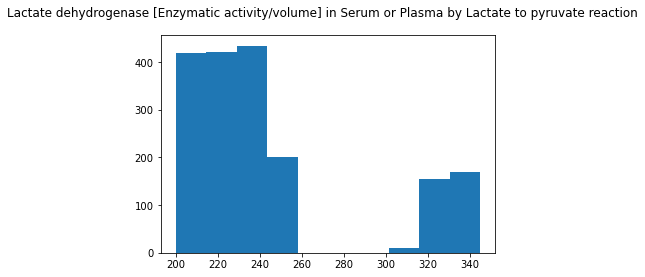

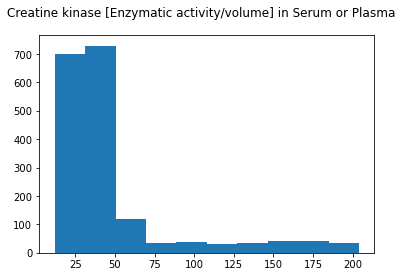

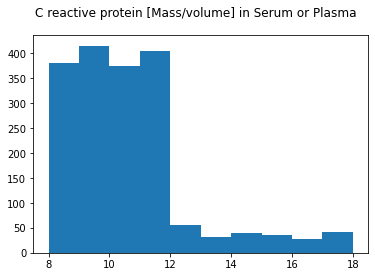

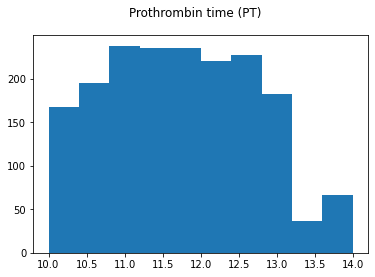

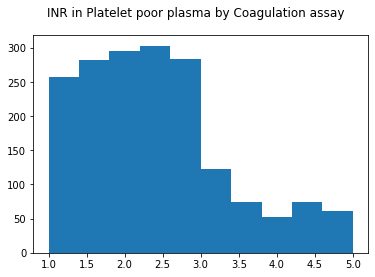

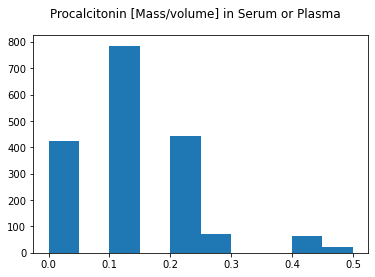

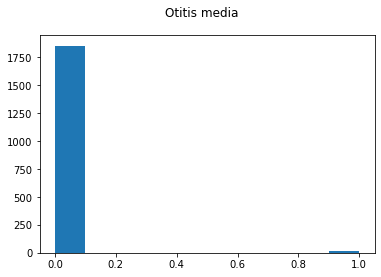

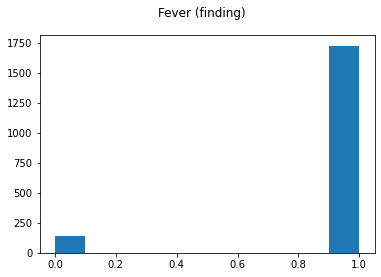

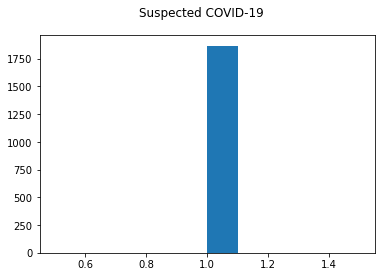

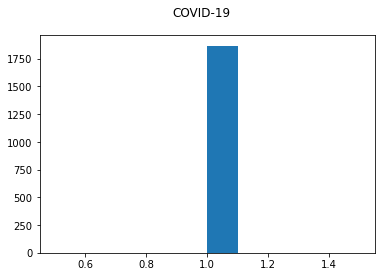

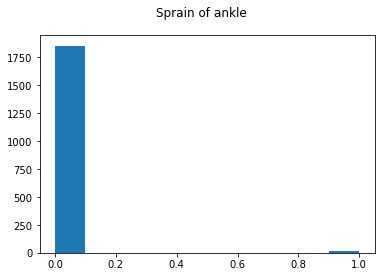

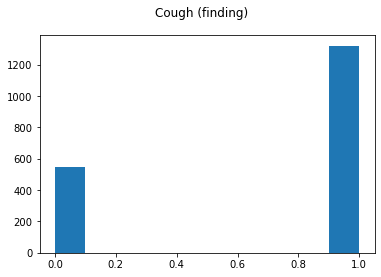

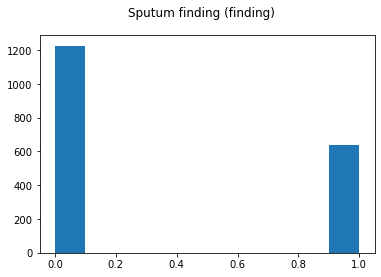

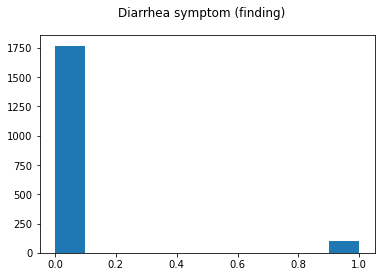

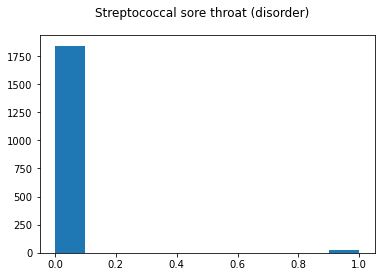

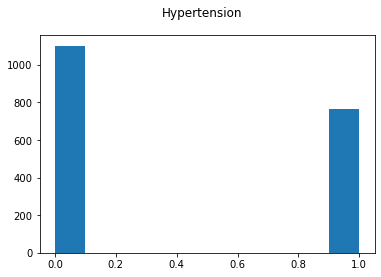

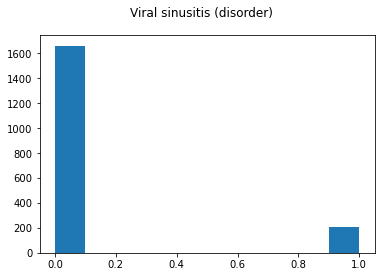

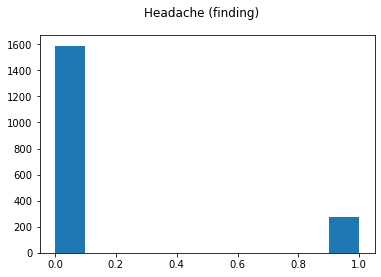

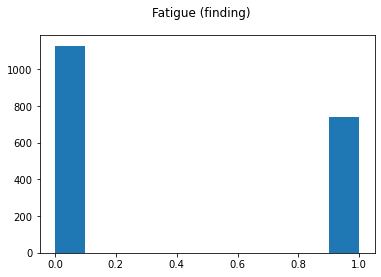

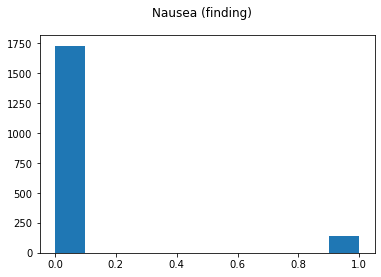

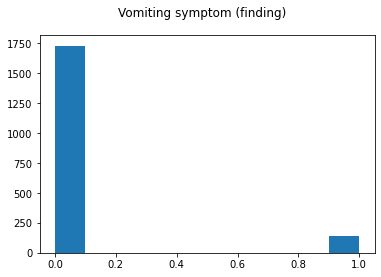

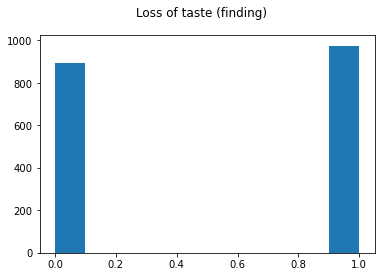

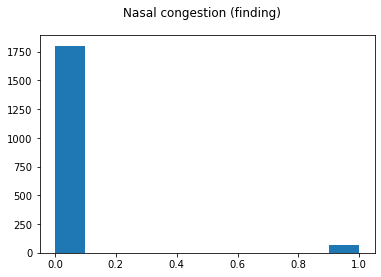

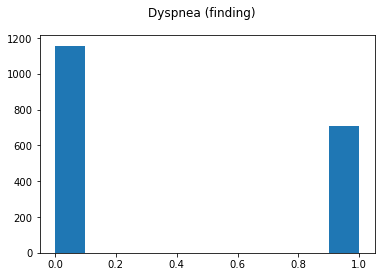

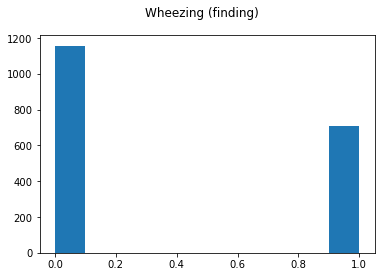

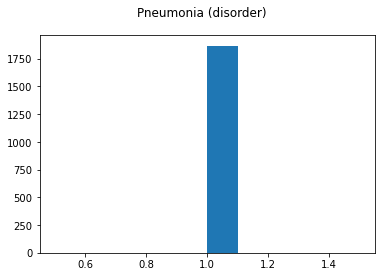

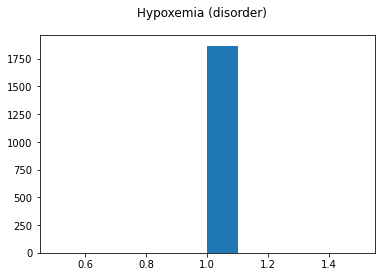

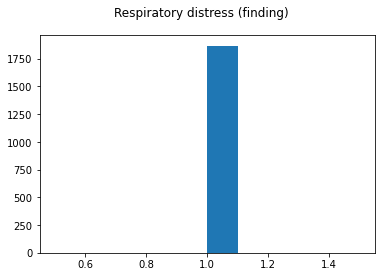

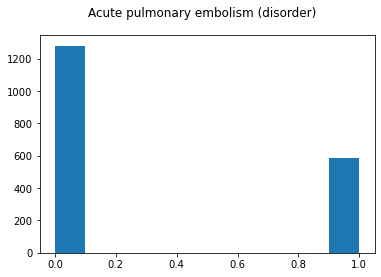

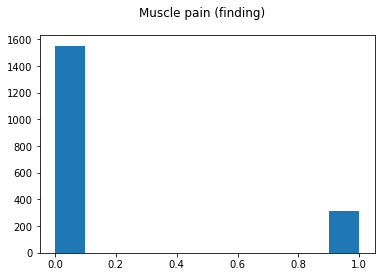

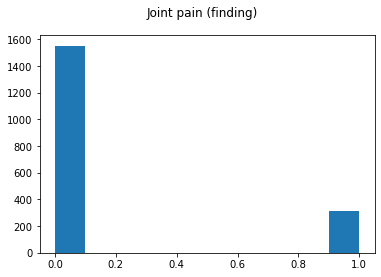

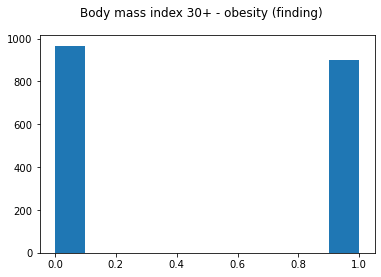

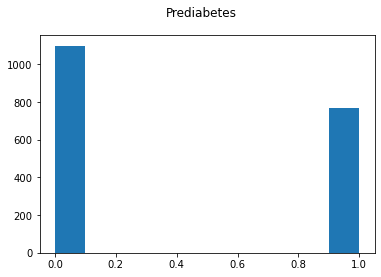

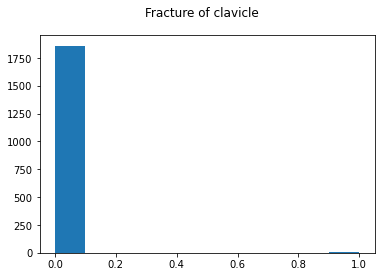

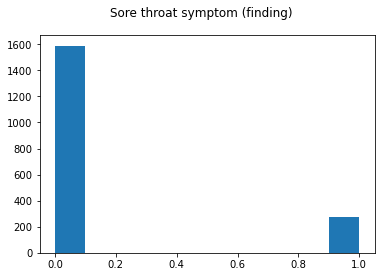

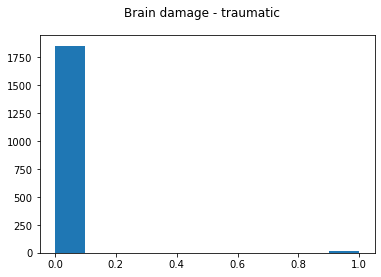

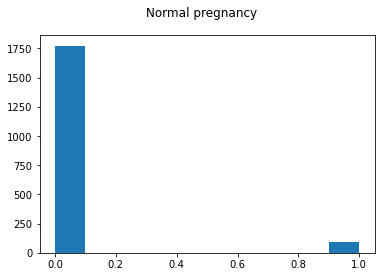

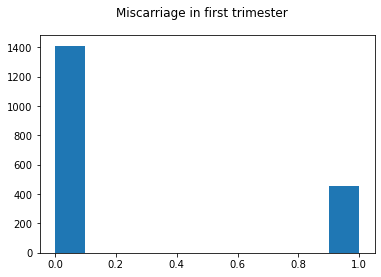

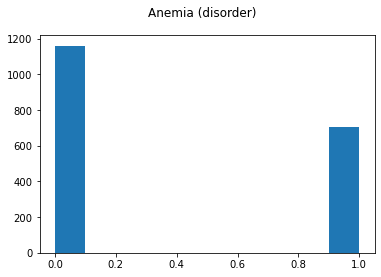

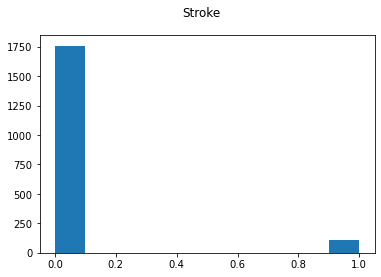

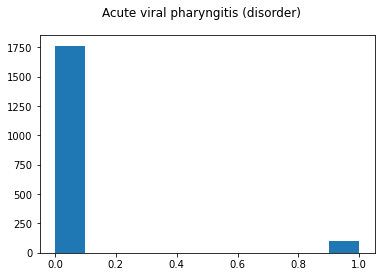

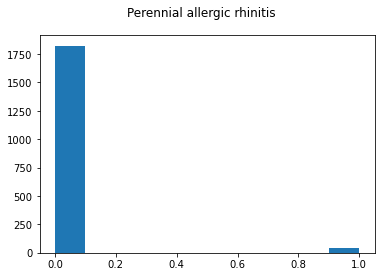

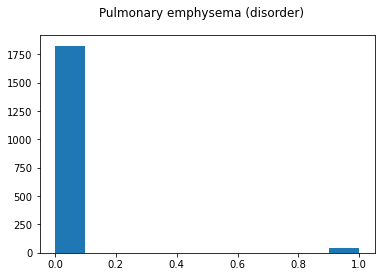

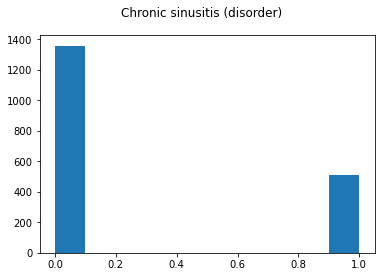

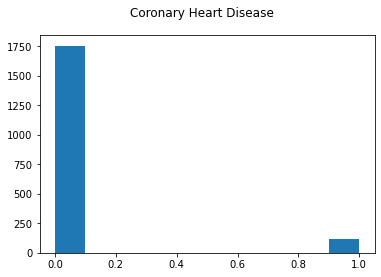

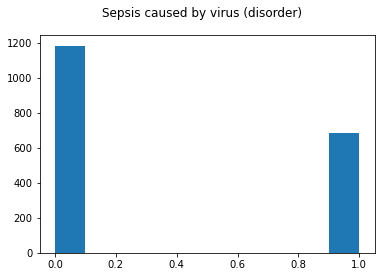

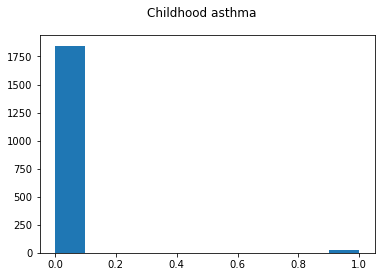

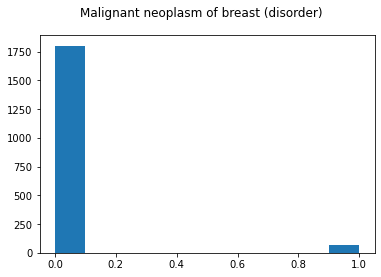

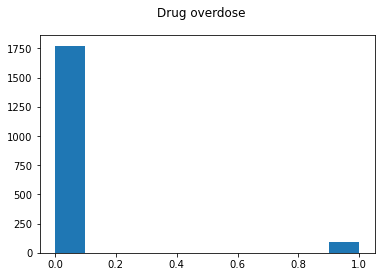

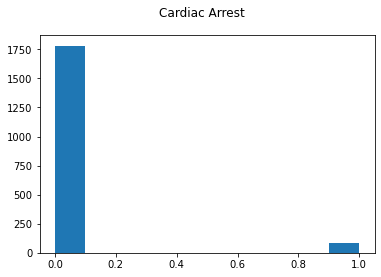

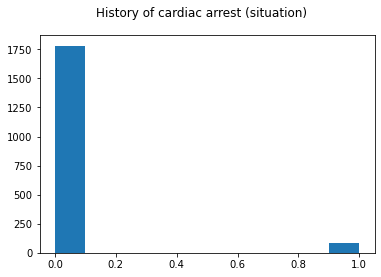

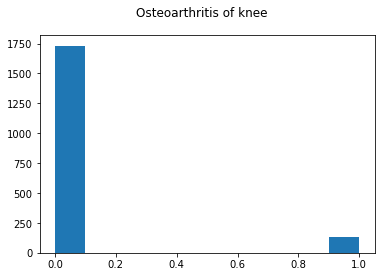

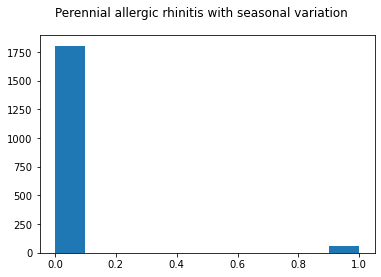

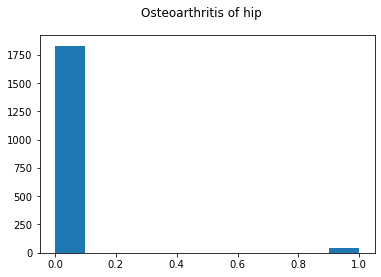

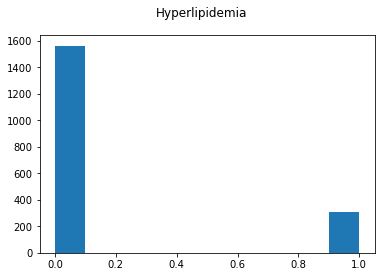

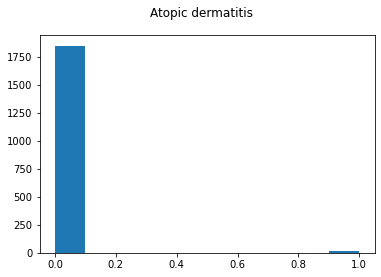

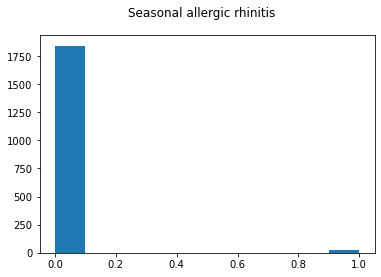

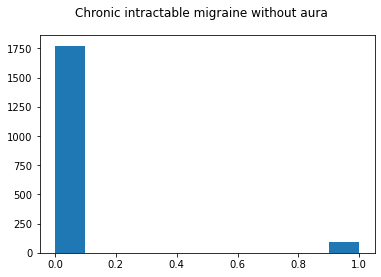

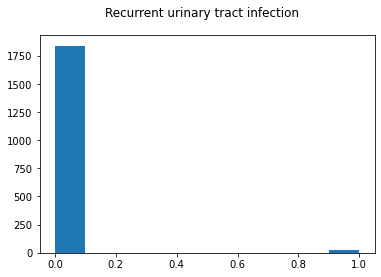

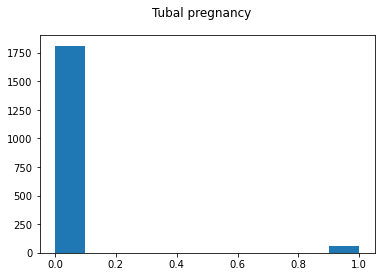

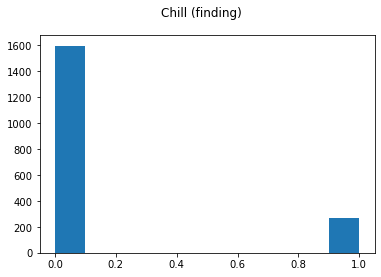

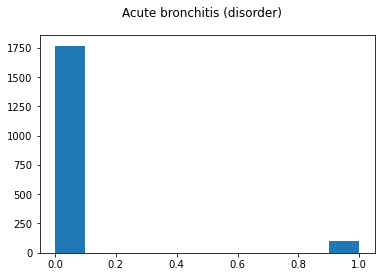

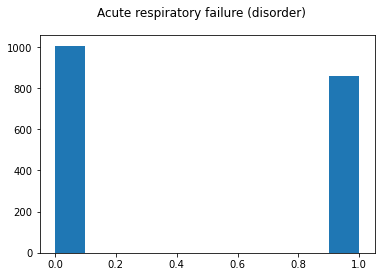

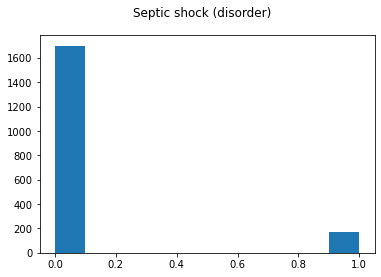

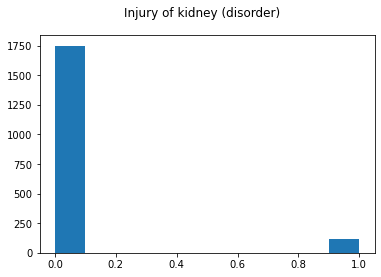

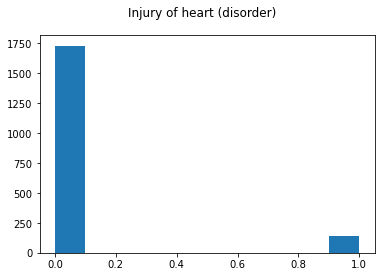

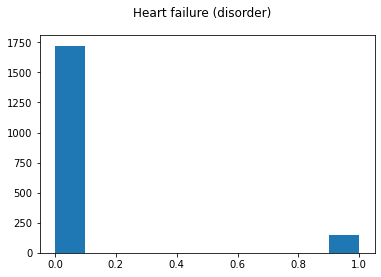

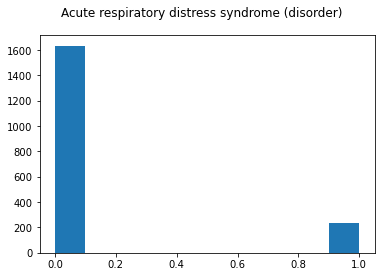

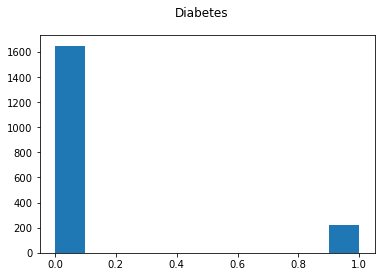

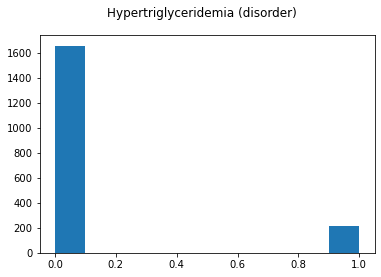

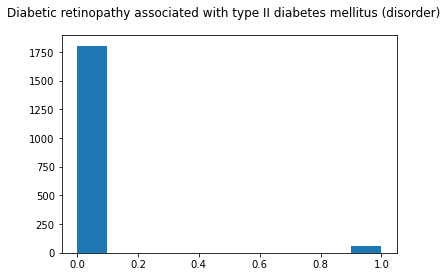

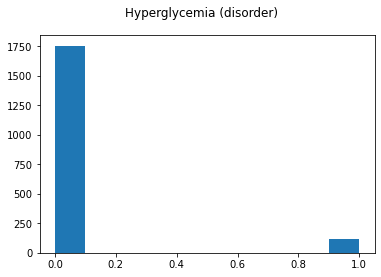

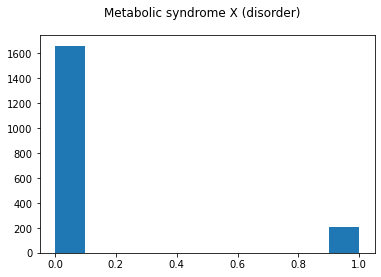

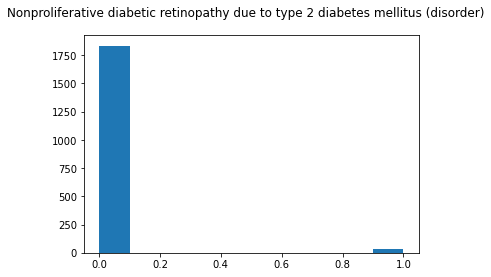

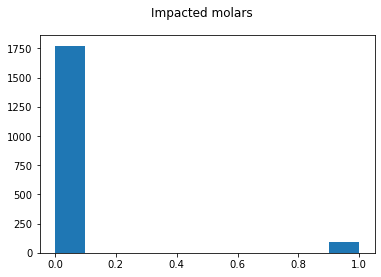

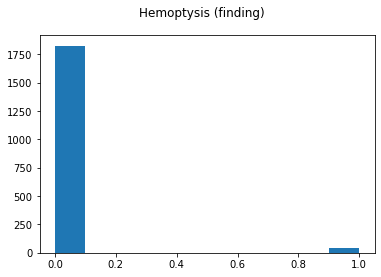

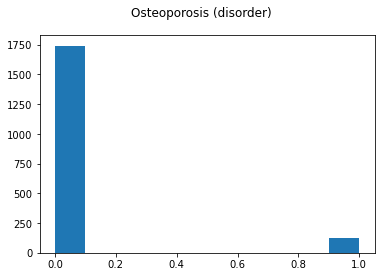

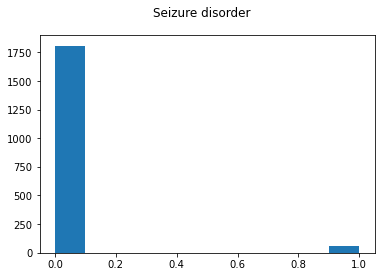

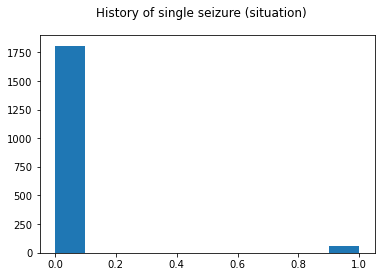

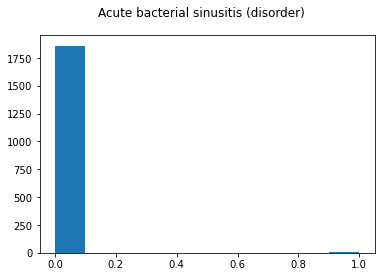

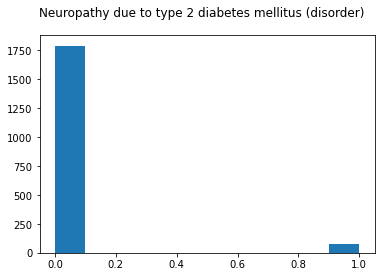

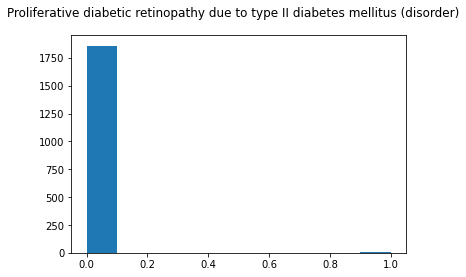

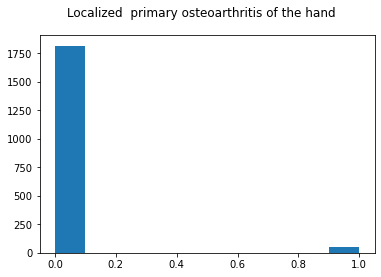

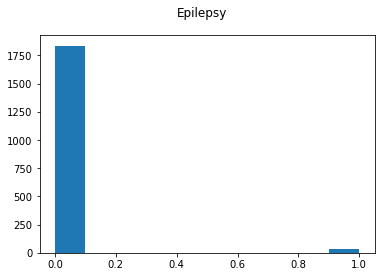

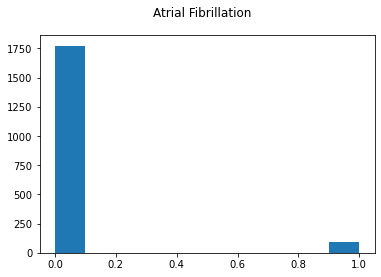

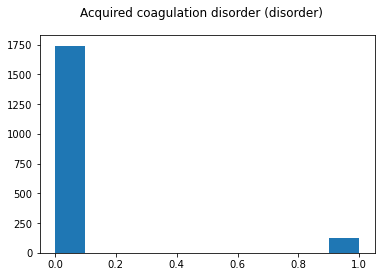

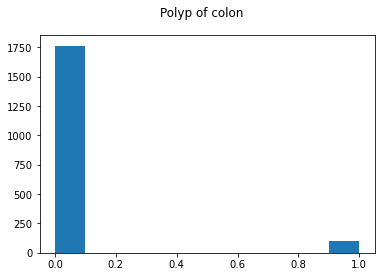

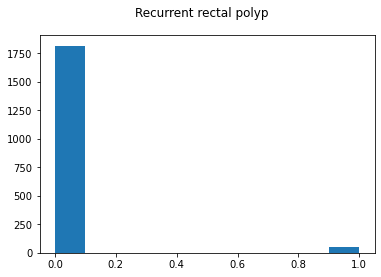

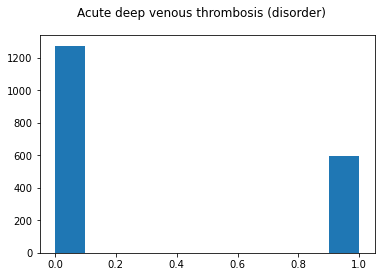

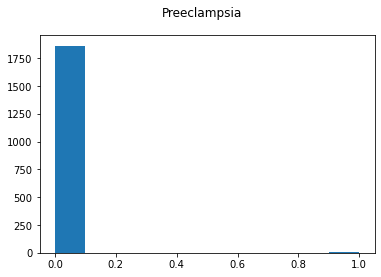

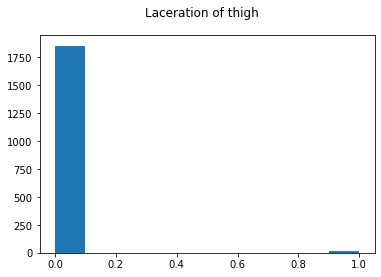

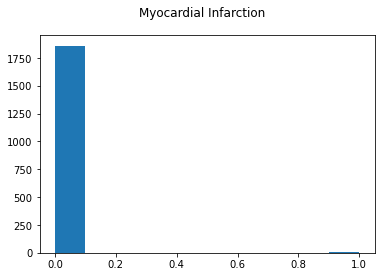

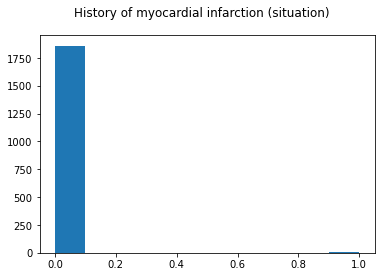

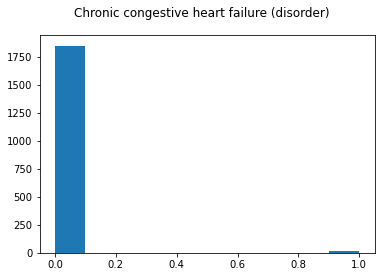

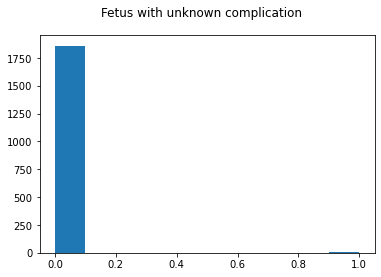

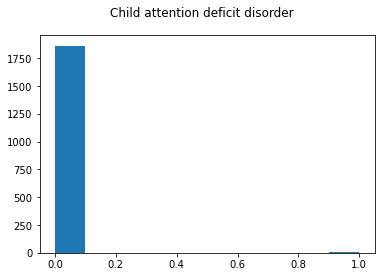

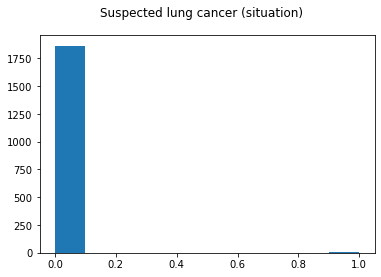

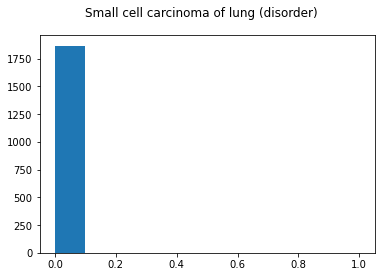

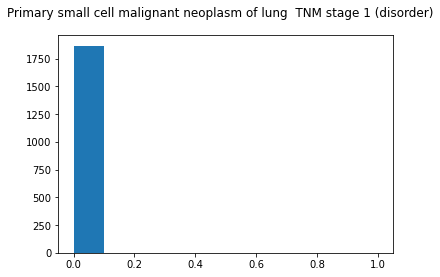

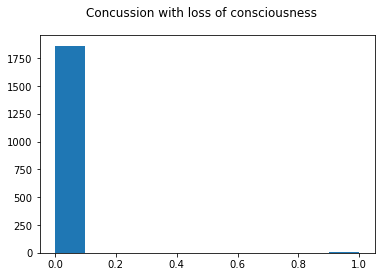

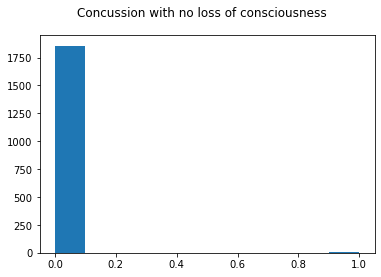

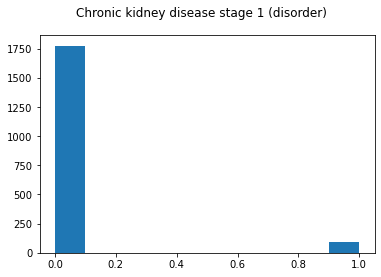

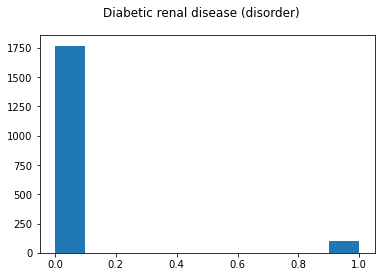

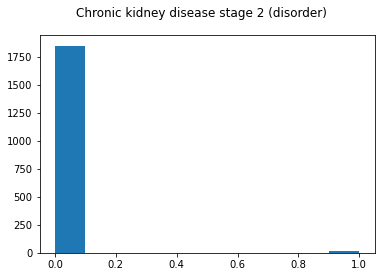

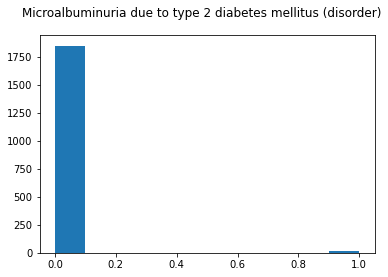

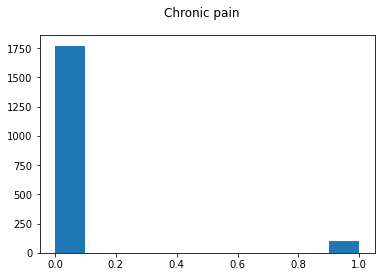

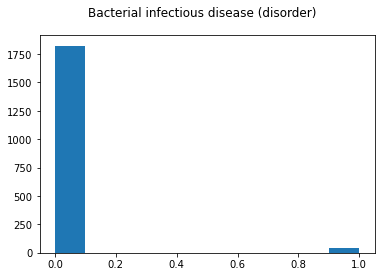

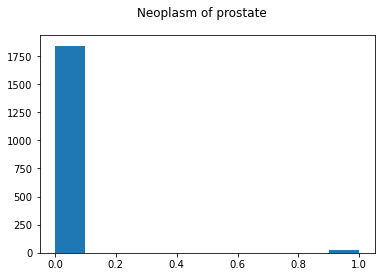

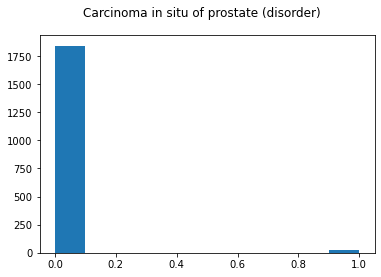

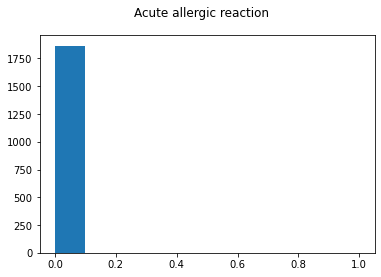

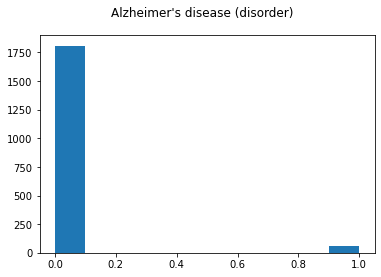

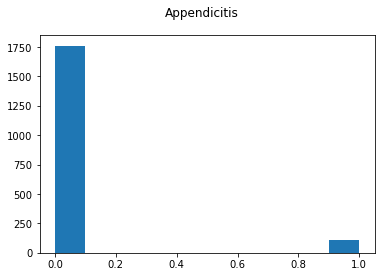

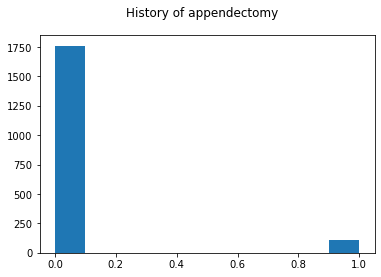

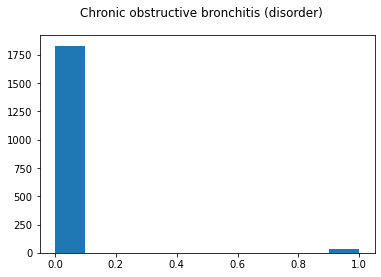

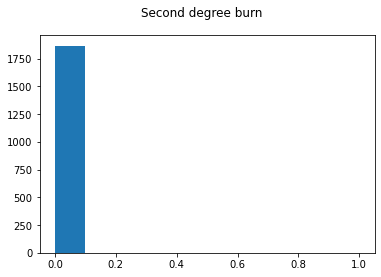

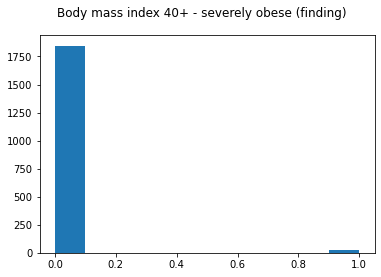

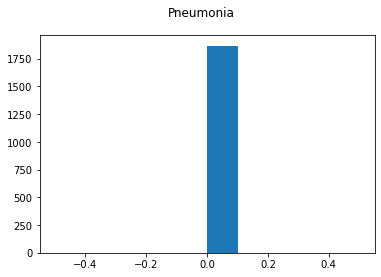

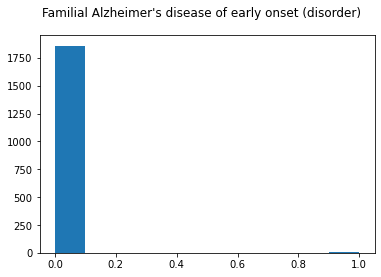

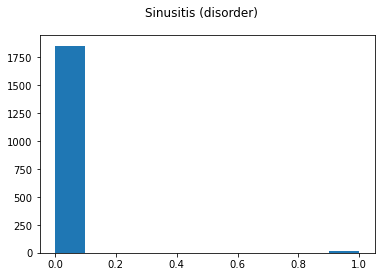

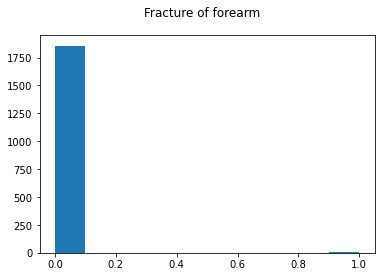

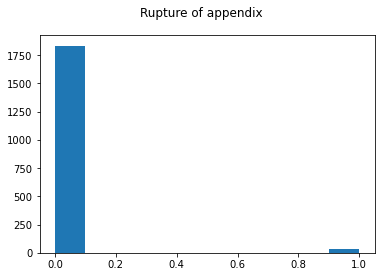

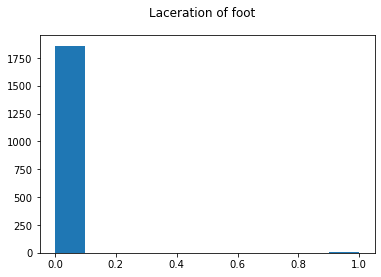

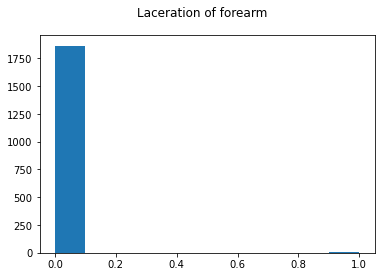

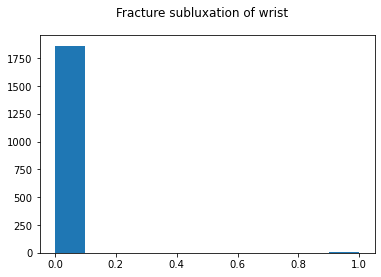

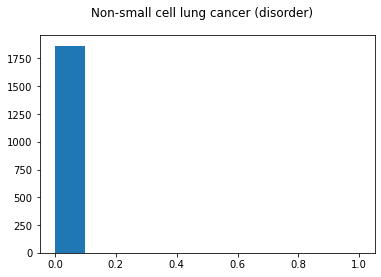

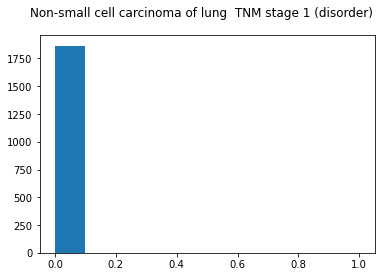

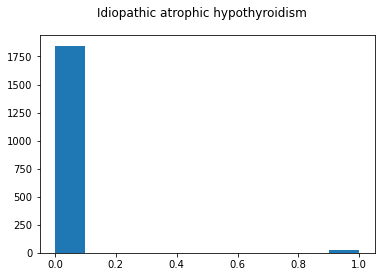

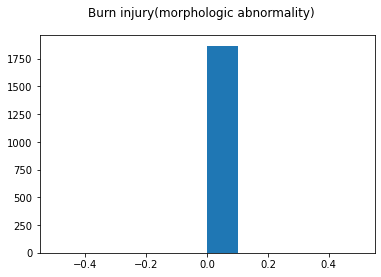

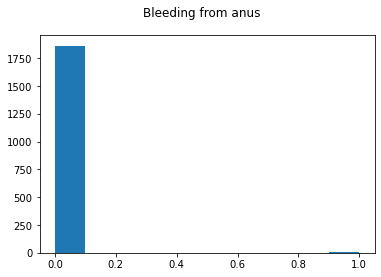

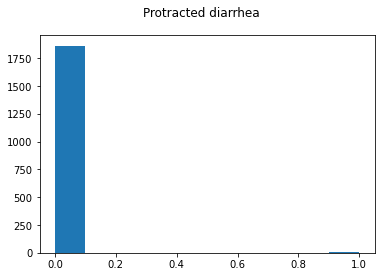

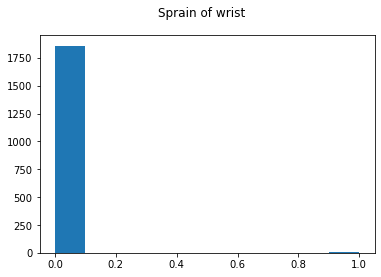

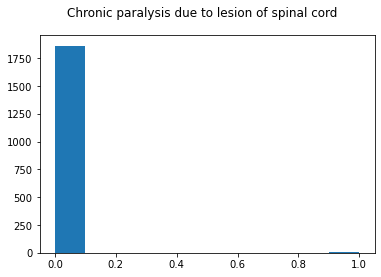

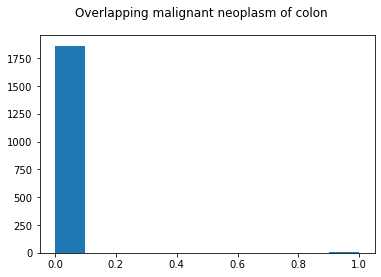

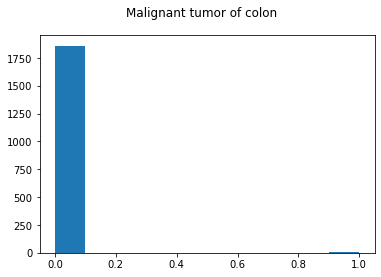

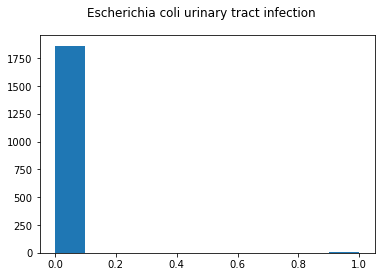

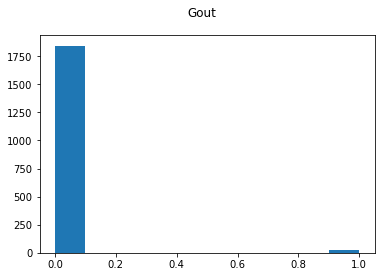

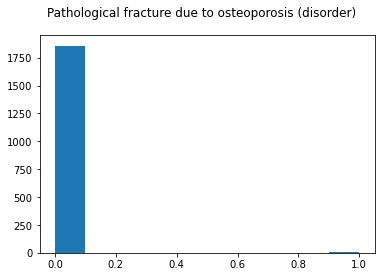

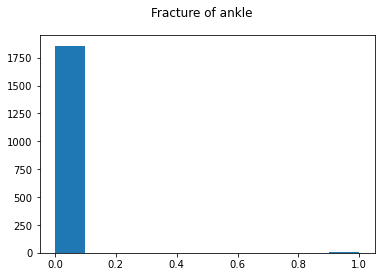

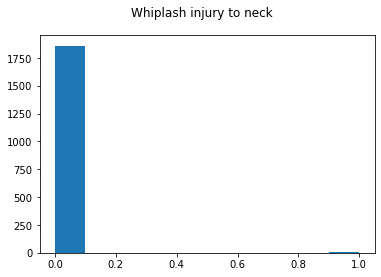

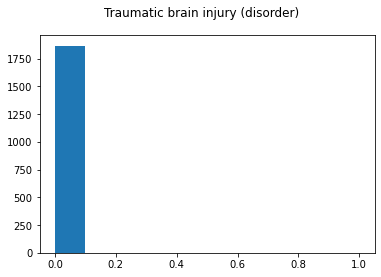

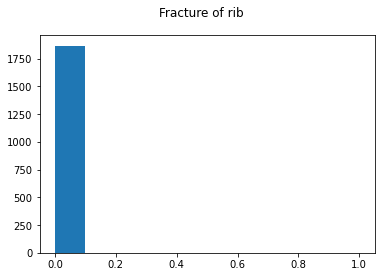

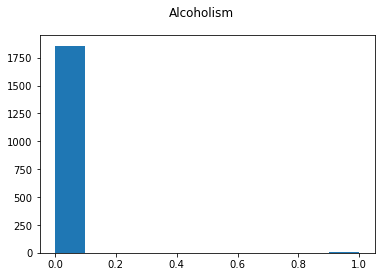

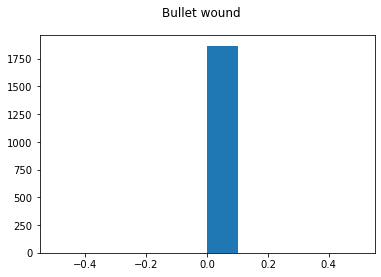

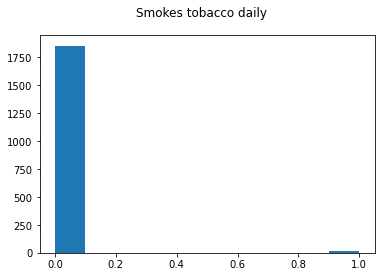

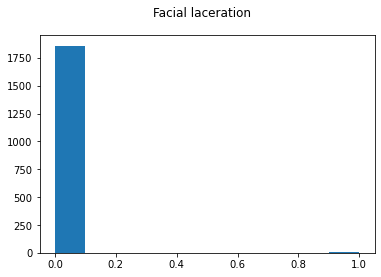

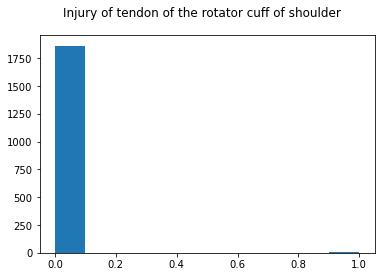

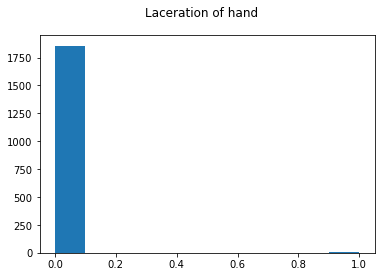

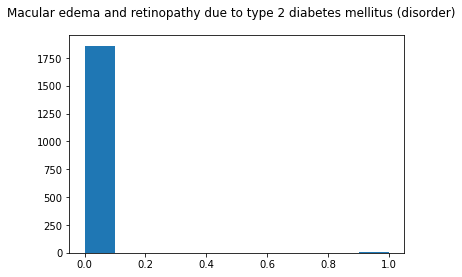

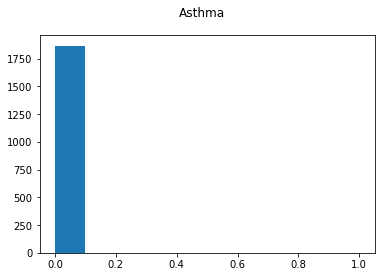

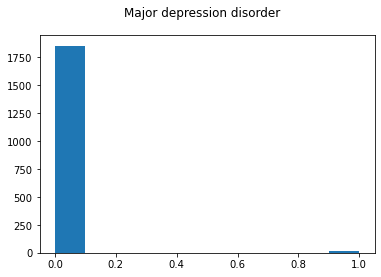

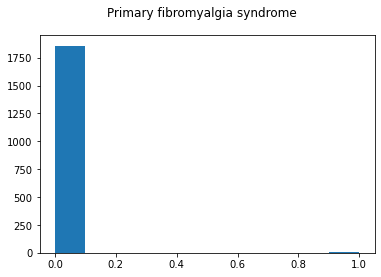

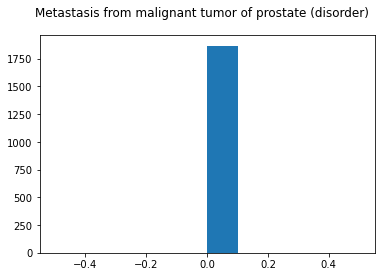

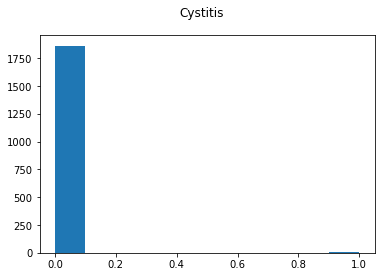

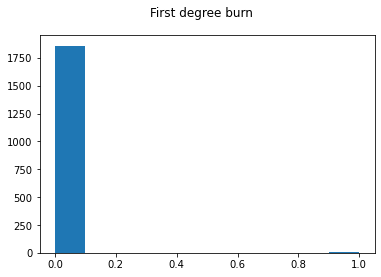

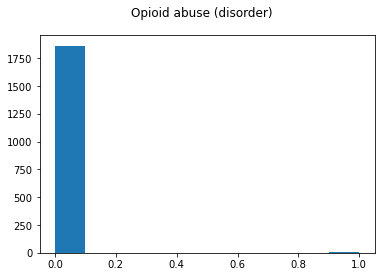

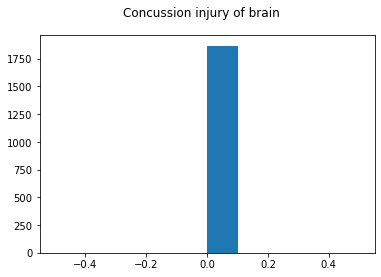

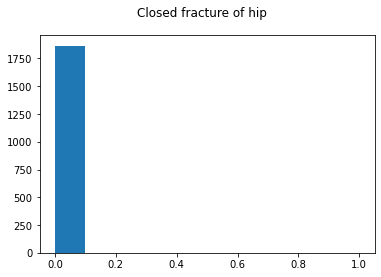

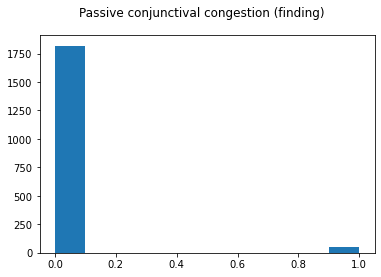

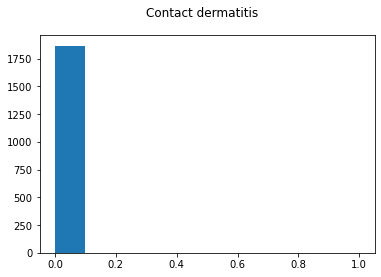

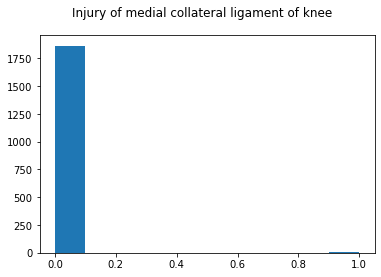

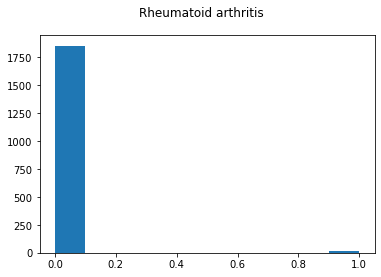

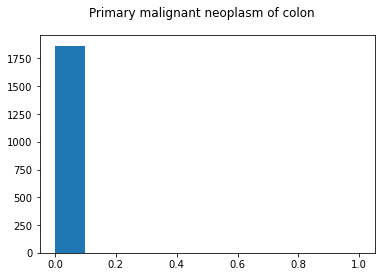

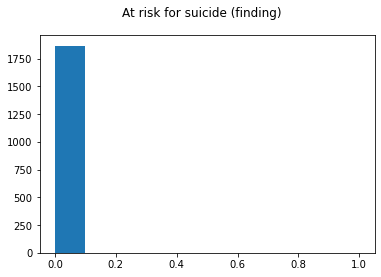

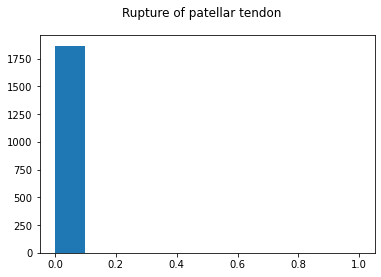

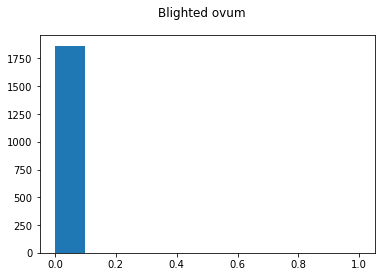

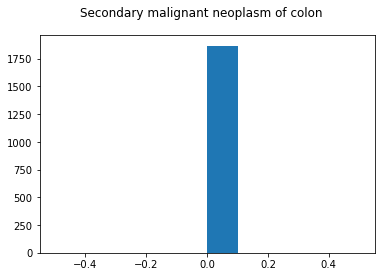

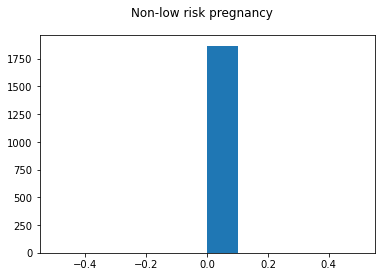

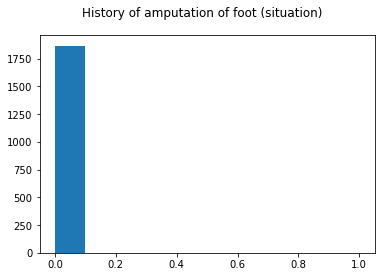

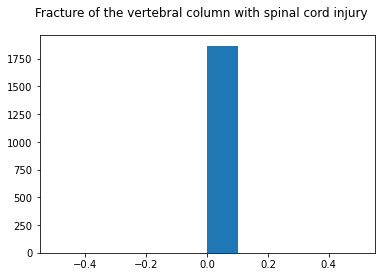

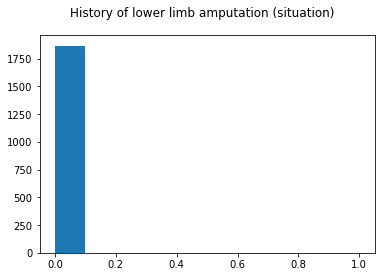

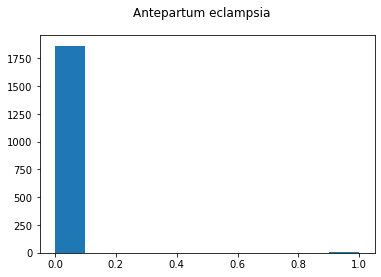

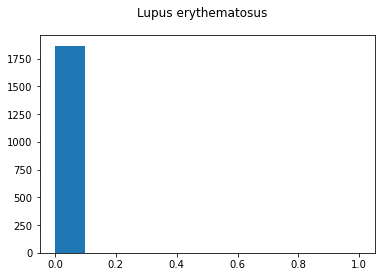

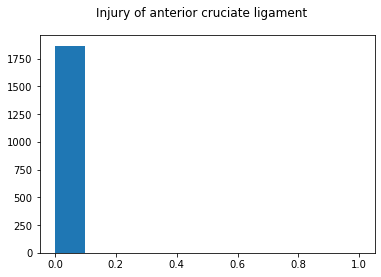

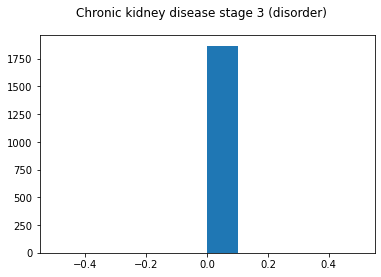

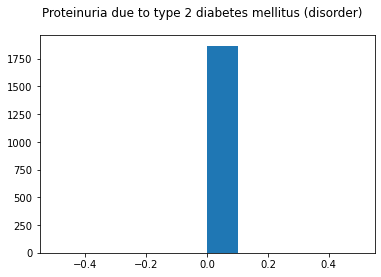

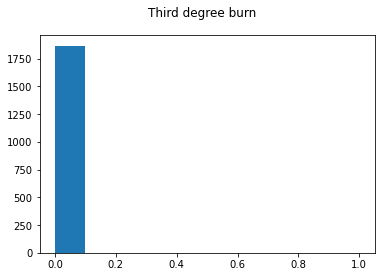

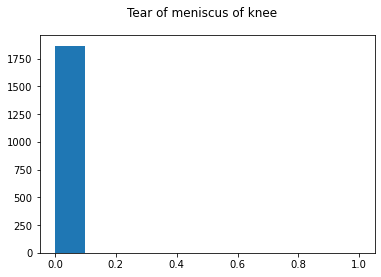

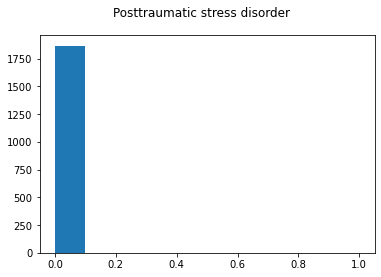

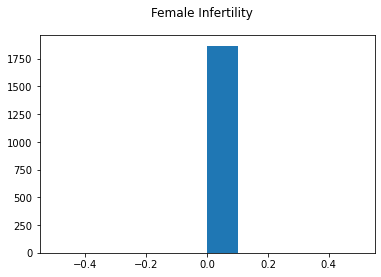

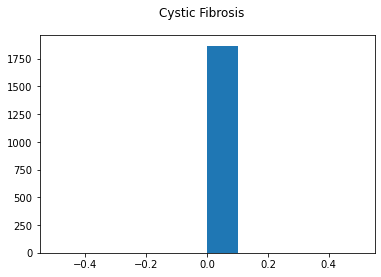

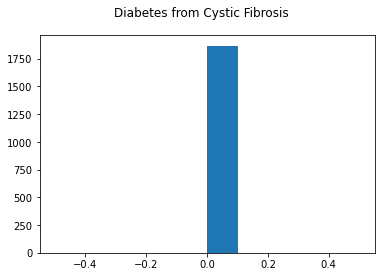

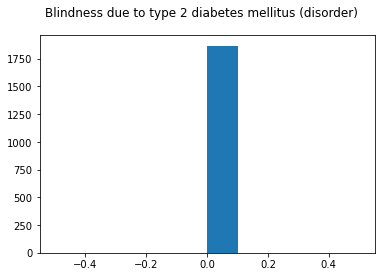

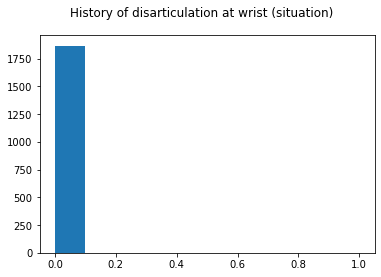

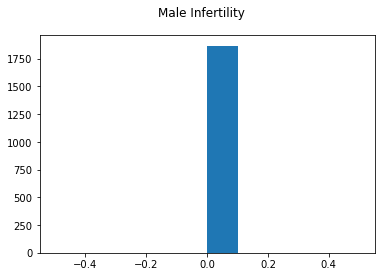

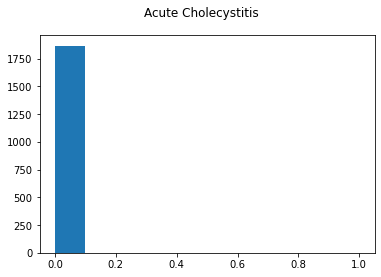

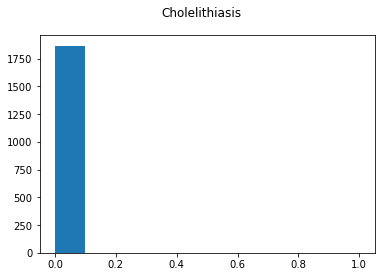

In [10]:
for column in observations_df.columns[:-3]:    
    plt.figure(figsize=(6, 4))
    plt.hist(observations_df[column])
    plt.suptitle(column)
    plt.show()

Let's look at whether any columns are correlated

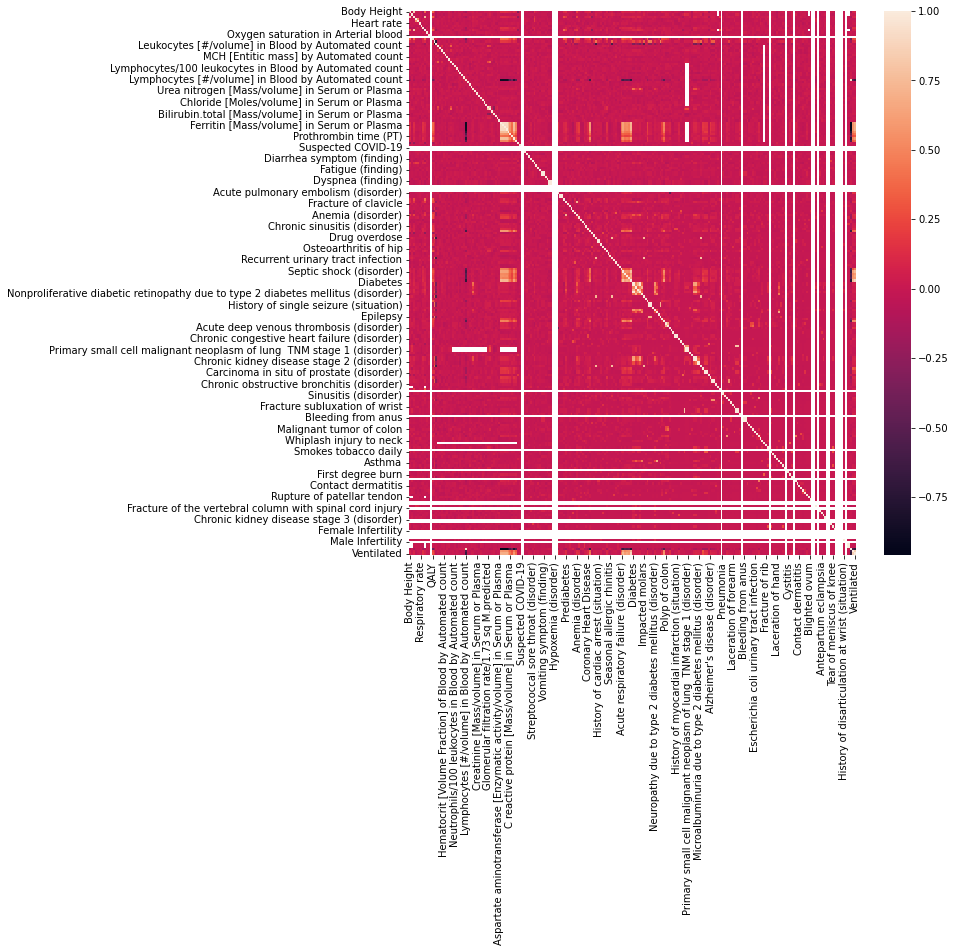

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(observations_df.corr())
plt.show()

Since there are 238 features remaining, the correlation heatmap isn't that useful. Let's find and drop any features that are > 0.95 correlated.
Since PCA can't use missing data (NaN) and some of the data are categorial, let's impute missing values using the median.

In [12]:
cor_matrix = observations_df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop[:])
cleaned_observations_df = observations_df.drop(labels=to_drop[:-1], axis=1)
cleaned_observations_df = observations_df.fillna(observations_df.median())

['Vomiting symptom (finding)', 'Wheezing (finding)', 'Joint pain (finding)', 'History of cardiac arrest (situation)', 'Hypertriglyceridemia (disorder)', 'Metabolic syndrome X (disorder)', 'History of single seizure (situation)', 'History of myocardial infarction (situation)', 'Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)', 'Diabetic renal disease (disorder)', 'Microalbuminuria due to type 2 diabetes mellitus (disorder)', 'Carcinoma in situ of prostate (disorder)', 'History of appendectomy', 'Non-small cell carcinoma of lung  TNM stage 1 (disorder)', 'Protracted diarrhea', 'Cholelithiasis', 'Survived']


Let's use T-SNE to visualize the high dimensional data reduced to 2D. 

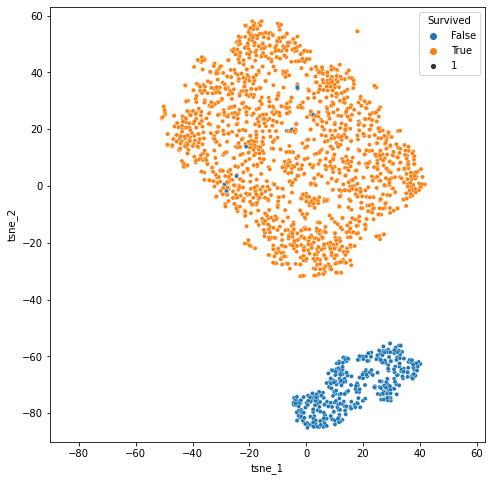

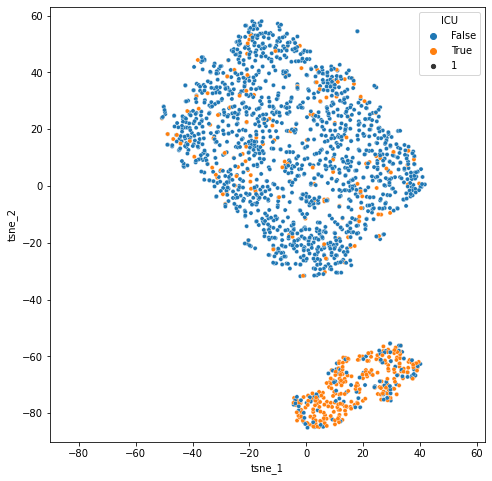

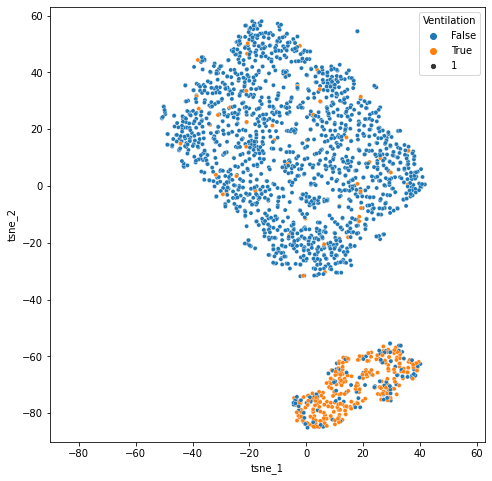

In [13]:
X = cleaned_observations_df.iloc[: , :-3]
y_survived = cleaned_observations_df.Survived
y_icu = cleaned_observations_df.ICU
y_vent = cleaned_observations_df.Ventilated
# print(X.shape, y.shape)

tsne = TSNE(2)
tsne_result = tsne.fit_transform(X)
tsne_result.shape # (1867, 2)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'Survived': y_survived})
fig, ax = plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='Survived', data=tsne_result_df, size = 1, ax=ax, s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
# plt.legend(['Survived', 'Died']);

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'ICU': y_icu})
fig, ax = plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='ICU', data=tsne_result_df, size = 1, ax=ax, s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
# plt.legend(['ICU', 'Hospital']);

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'Ventilation': y_vent})
fig, ax = plt.subplots(1, figsize=(8, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='Ventilation', data=tsne_result_df, size = 1, ax=ax, s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
# plt.legend(['Ventilated', 'Not Ventilated'])

There are two distinct clusters with a bit of color (outcome) mismatch. 

# Modeling
## PCA
Let's use PCA to reduce the number of features. The data needs to be scaled first. Let's then use PCA with a set explained variance of 0.95. 

Number of components after PCA: 163


Text(0.5, 1.0, 'Explained Variance of PCA Features')

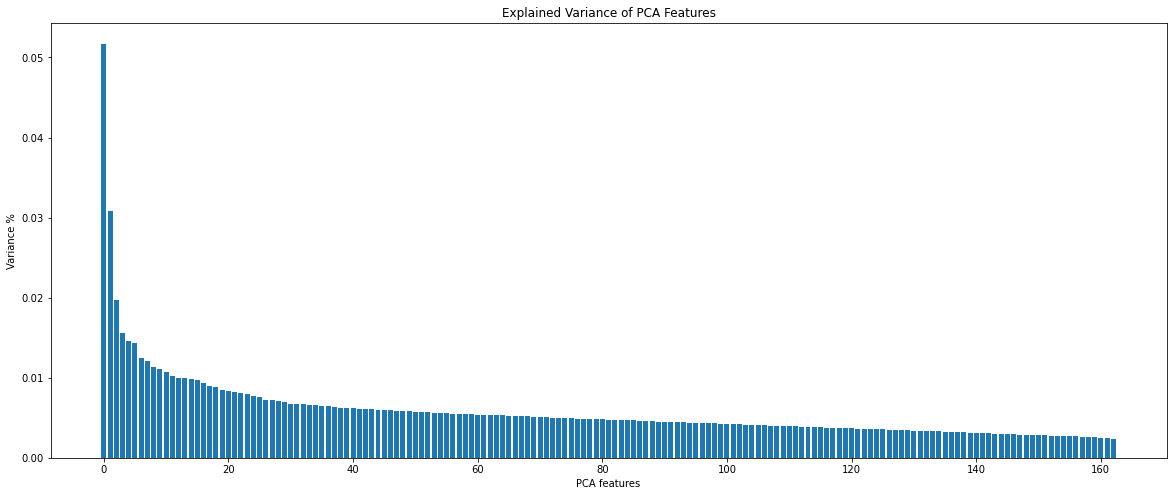

In [14]:
features = cleaned_observations_df.columns[:-3]
x = cleaned_observations_df.loc[:, features].values
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(0.95)
principle_components = pca.fit_transform(x)
print(f"Number of components after PCA: {pca.n_components_}")

features = range(pca.n_components_)
fig, ax = plt.subplots(1, figsize=(20, 8))
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('Variance %')
plt.title('Explained Variance of PCA Features')


## K-Means
After finding the principal components, we can use k-means clustering on them to classify outcomes. 

In [15]:
def label_permute_compare(yt, yp, metric, n=2):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    labels = [0, 1]
    yp_names = pd.Series(yp).map({0:0, 1:1})
    best_perm = []
    best_score = 0
    perms = itertools.permutations(labels)
    for perm in perms:
        temp = yp_names.map({labels[0]:perm[0], labels[1]:perm[1]})
        if metric == "acc":
            score = accuracy_score(yt, temp)
        elif metric == "prec":
            score = precision_score(yt, temp)
        elif metric == "recall":
            score = recall_score(yt, temp)
        else:
            score = roc_auc_score(yt, temp)
        if score >= best_score:
            best_score = score
            best_perm = perm
    
    return ([labels.index(x) for x in best_perm], best_score)

Text(0.5, 0.98, 'K-Means Metrics')

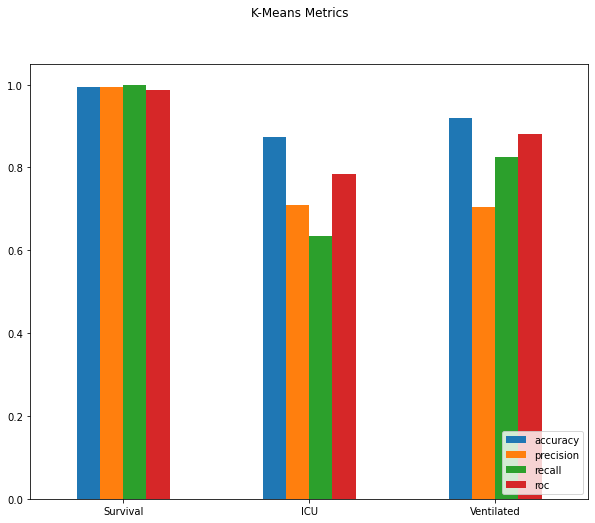

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(principle_components, cleaned_observations_df['Survived'].astype(int), test_size=0.20, random_state=42)
kmeans = KMeans(n_clusters=2).fit(principle_components)
y_survived = cleaned_observations_df['Survived'].astype(int)
y_icu = cleaned_observations_df['ICU'].astype(int)
y_vent = cleaned_observations_df['Ventilated'].astype(int)

predicted_labels = kmeans.labels_


# print(f"Survival accuracy: {label_permute_compare(y_survived, predicted_labels, 'acc')[1]:.3f}")
# print(f"ICU accuracy: {label_permute_compare(y_icu, predicted_labels, 'acc')[1]:.3f}")
# print(f"Ventilation accuracy: {label_permute_compare(y_vent, predicted_labels, 'acc')[1]:.3f}")
res = {
    "accuracy": [label_permute_compare(y_survived, predicted_labels, "acc")[1], 
                 label_permute_compare(y_icu, predicted_labels, "acc")[1], 
                 label_permute_compare(y_vent, predicted_labels, "acc")[1]],
    "precision": [label_permute_compare(y_survived, predicted_labels, "prec")[1], 
                 label_permute_compare(y_icu, predicted_labels, "prec")[1], 
                 label_permute_compare(y_vent, predicted_labels, "prec")[1]],
    "recall": [label_permute_compare(y_survived, predicted_labels, "recall")[1], 
                 label_permute_compare(y_icu, predicted_labels, "recall")[1], 
                 label_permute_compare(y_vent, predicted_labels, "recall")[1]],
    "roc": [label_permute_compare(y_survived, predicted_labels, "roc")[1], 
                 label_permute_compare(y_icu, predicted_labels, "roc")[1], 
                 label_permute_compare(y_vent, predicted_labels, "roc")[1]]
}
km_res = pd.DataFrame(data=res, index=['Survival', 'ICU', 'Ventilated'])
km_res.plot.bar(rot=0,figsize=(10,8))
plt.legend(loc="lower right")
plt.suptitle("K-Means Metrics")

### K-Means Hyperparameter Optimization
K-Means can use different algorithms. There aren't really any hyperparameters other than the number of clusters which is set to 2 since outcomes are binary. You only need to increase max_iters if it fails to converge. 

In [18]:
def map_predicted(labels, labelorder):
    names = [0, 1]
    mapping = {}
    for i, n in enumerate(labelorder):
        mapping[n] = names[i]
    return pd.Series(labels).map(mapping)

def km_cluster(yt):
    algorithms = ['elkan', "full"]
    
    best_labels = []
    best_algo = ''
    best_acc = 0
    best_cm = 0
    
    for algo in algorithms:
        kmeans = KMeans(n_clusters=2, random_state=0, init='k-means++', algorithm=algo).fit(principle_components)
        labelorder, acc = label_permute_compare(yt, kmeans.labels_, "acc")
        yp = map_predicted(kmeans.labels_, labelorder)
        acc = accuracy_score(yt, yp)
        print(f'Algorithm: {algo}, accuracy: {acc}')
        if acc >= best_acc:
            best_acc = acc
            best_algo = algo
            best_labels = labelorder
    print(f'Best Algorithm: {best_algo}')
    print(f'Best Accuracy: {best_acc}')
    print(f'Labels: {best_labels}')

km_cluster(y_survived)
km_cluster(y_icu)
km_cluster(y_vent)

Algorithm: elkan, accuracy: 0.9951794322442421
Algorithm: full, accuracy: 0.9951794322442421
Best Algorithm: full
Best Accuracy: 0.9951794322442421
Labels: [0, 1]
Algorithm: elkan, accuracy: 0.874129619710766


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Algorithm: full, accuracy: 0.874129619710766
Best Algorithm: full
Best Accuracy: 0.874129619710766
Labels: [1, 0]
Algorithm: elkan, accuracy: 0.9201928227102303
Algorithm: full, accuracy: 0.9201928227102303
Best Algorithm: full
Best Accuracy: 0.9201928227102303
Labels: [1, 0]


C:\Users\Andrew\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


The algorithm did not make a difference for K-means clustering. 

## t-SNE and DBSCAN

DBSCAN is another clustering algorithm, but can make clusters of any shape as opposed to k-means which are convex shaped. DBSCAN can run on dimensionality-reduced data so we will re-use the t-SNE result. 

Estimated number of clusters: 2
Estimated number of noise points: 0


Text(0, 0.5, '$t-SNE_2$')

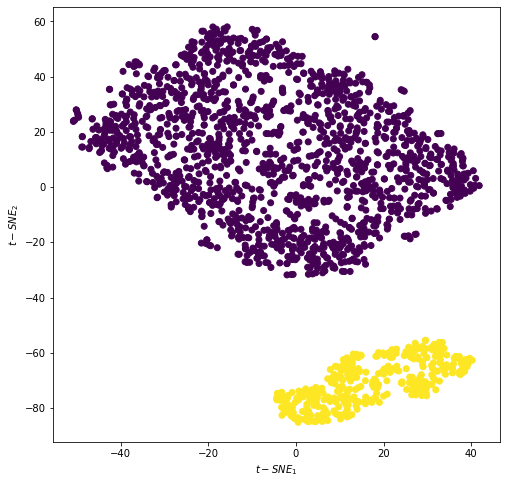

In [76]:
# db = DBSCAN(eps=10, min_samples=163*2).fit(principle_components)
db = DBSCAN(eps=15, min_samples=4).fit(tsne_result)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
plt.figure(figsize=(8,8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, label=y_survived)
plt.xlabel("$t-SNE_1$")
plt.ylabel("$t-SNE_2$")


DBSCAN found two clusters and the top right point could be an outlier depending on the epsilon value. Let's keep epsilon large so that all points are given a label other than -1 (noise) so that we can calculate scores. Recall that the clusters weren't evenly divided by any of the outcomes. 

Text(0.5, 0.98, 't-SNE and DBSCAN Metrics')

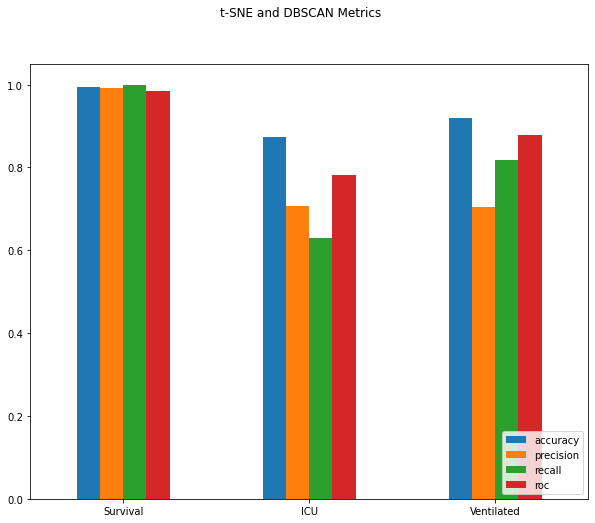

In [78]:
res = {
    "accuracy": [label_permute_compare(y_survived, labels, "acc")[1], 
                 label_permute_compare(y_icu, labels, "acc")[1], 
                 label_permute_compare(y_vent, labels, "acc")[1]],
    "precision": [label_permute_compare(y_survived, labels, "prec")[1], 
                 label_permute_compare(y_icu, labels, "prec")[1], 
                 label_permute_compare(y_vent, labels, "prec")[1]],
    "recall": [label_permute_compare(y_survived, labels, "recall")[1], 
                 label_permute_compare(y_icu, labels, "recall")[1], 
                 label_permute_compare(y_vent, labels, "recall")[1]],
    "roc": [label_permute_compare(y_survived, labels, "roc")[1], 
                 label_permute_compare(y_icu, labels, "roc")[1], 
                 label_permute_compare(y_vent, labels, "roc")[1]]
}
db_res = pd.DataFrame(data=res, index=['Survival', 'ICU', 'Ventilated'])
db_res.plot.bar(rot=0,figsize=(10,8))
plt.legend(loc="lower right")
plt.suptitle("t-SNE and DBSCAN Metrics")

This looks very similar to the k-means results

## Logistic Regression

Let's see how a supervised learning method performs at classifying outcomes.  

Text(0.5, 0.98, 'Logistic Regression Metrics')

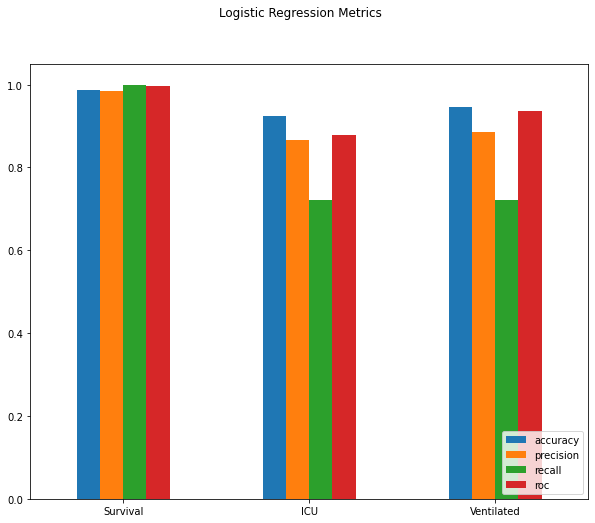

In [19]:
# Survival ----------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(principle_components, cleaned_observations_df['Survived'].astype(int), test_size=0.20, random_state=42)
log = LogisticRegression().fit(X_train, y_train)

# Accuracy, precision and recall
survival_accuracy = log.score(X_test, y_test)
# print(f"Survival:\nAccuracy: {survival_accuracy:.3f}")
survival_precision = precision_score(y_test, log.predict(X_test))
# print(f"Precision: {survival_precision:.3f}")
survival_recall = recall_score(y_test, log.predict(X_test))
# print(f"Recall: {survival_recall:.3f}")

# ROC AOC
y_test_pred = log.predict_proba(X_test)[:,1]
survival_roc = roc_auc_score(y_test, y_test_pred)
# print(f"AUC Test: {survival_roc:.3f}")

# ICU --------------------------------------
X_train, X_test, y_train, y_test = train_test_split(principle_components, cleaned_observations_df['ICU'].astype(int), test_size=0.20, random_state=42)
log = LogisticRegression().fit(X_train, y_train)

# Accuracy, precision and recall
icu_accuracy = log.score(X_test, y_test)
# print(f"ICU:\nAccuracy: {icu_accuracy:.3f}")
icu_precision = precision_score(y_test, log.predict(X_test))
# print(f"Precision: {icu_precision:.3f}")
icu_recall = recall_score(y_test, log.predict(X_test))
# print(f"Recall: {icu_recall:.3f}")

# ROC AOC
y_test_pred = log.predict_proba(X_test)[:,1]
icu_roc = roc_auc_score(y_test, y_test_pred)
# print(f"AUC Test: {icu_roc:.3f}")

# Ventilation --------------------------------
X_train, X_test, y_train, y_test = train_test_split(principle_components, cleaned_observations_df['Ventilated'].astype(int), test_size=0.20, random_state=42)
log = LogisticRegression().fit(X_train, y_train)

# Accuracy, precision and recall
vent_accuracy = log.score(X_test, y_test)
# print(f"Ventilation:\nAccuracy: {vent_accuracy:.3f}")
vent_precision = precision_score(y_test, log.predict(X_test))
# print(f"Precision: {vent_precision:.3f}")
vent_recall = recall_score(y_test, log.predict(X_test))
# print(f"Recall: {vent_recall:.3f}")

# ROC AOC
y_test_pred = log.predict_proba(X_test)[:,1]
vent_roc = roc_auc_score(y_test, y_test_pred)
# print(f"AUC Test: {vent_roc:.3f}")

res = {
    "accuracy": [survival_accuracy, icu_accuracy, vent_accuracy],
    "precision": [survival_precision, icu_precision, vent_precision],
    "recall": [survival_recall, icu_recall, vent_recall],
    "roc": [survival_roc, icu_roc, vent_roc]
}
res = pd.DataFrame(data=res, index=['Survival', 'ICU', 'Ventilated'])
res.plot.bar(rot=0,figsize=(10,8))
plt.legend(loc="lower right")
plt.suptitle("Logistic Regression Metrics")

## XGBoost

Let's see how another supervised learning algorithm, XGBoost, does

[0]	validation_0-auc:0.96635
[1]	validation_0-auc:0.97434
[2]	validation_0-auc:0.97712
[3]	validation_0-auc:0.97715
[4]	validation_0-auc:0.97476
[5]	validation_0-auc:0.97476
[6]	validation_0-auc:0.97625
[7]	validation_0-auc:0.97657
[8]	validation_0-auc:0.97513
[9]	validation_0-auc:0.97715
[10]	validation_0-auc:0.97696
[11]	validation_0-auc:0.97914
[12]	validation_0-auc:0.97909
[13]	validation_0-auc:0.98087
[14]	validation_0-auc:0.98012
[15]	validation_0-auc:0.97869
[16]	validation_0-auc:0.97975
[17]	validation_0-auc:0.97975
[18]	validation_0-auc:0.97797
[19]	validation_0-auc:0.97776
[20]	validation_0-auc:0.97723
[21]	validation_0-auc:0.97983
[22]	validation_0-auc:0.97972
[23]	validation_0-auc:0.97951
[0]	validation_0-auc:0.80579
[1]	validation_0-auc:0.80691
[2]	validation_0-auc:0.81956
[3]	validation_0-auc:0.84736
[4]	validation_0-auc:0.83290
[5]	validation_0-auc:0.83881
[6]	validation_0-auc:0.84198
[7]	validation_0-auc:0.84094
[8]	validation_0-auc:0.86217
[9]	validation_0-auc:0.86166


Text(0.5, 0.98, 'XGBoost Metrics')

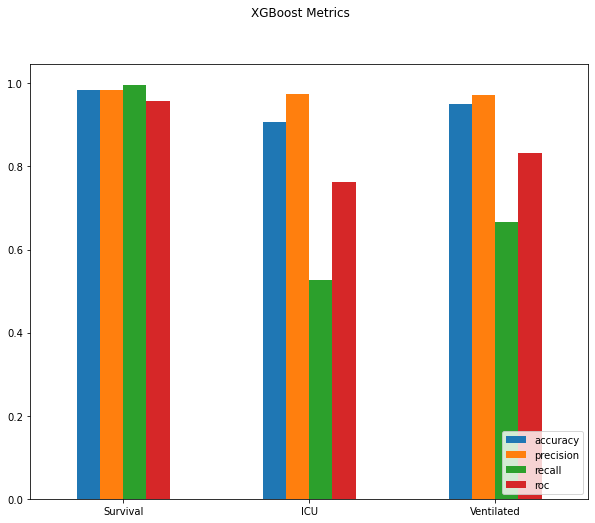

In [20]:
import xgboost

model_xgboost = xgboost.XGBClassifier(learning_rate=0.1,
                                      max_depth=5,
                                      n_estimators=5000,
                                      subsample=0.5,
                                      colsample_bytree=0.5,
                                      eval_metric='auc',
                                      early_stopping_rounds=10,
                                      verbosity=0)
# Survived
X_train, X_test, y_train_survived, y_test_survived = train_test_split(principle_components, cleaned_observations_df['Survived'].astype(int), test_size=0.20, random_state=42)

eval_set = [(X_test, y_test_survived)]
model_xgboost.fit(X_train, y_train_survived, eval_set=eval_set)

xg_survival_accuracy = model_xgboost.score(X_test, y_test_survived)
xg_survival_precision = precision_score(y_test_survived, model_xgboost.predict(X_test))
xg_survival_recall = recall_score(y_test_survived, model_xgboost.predict(X_test))
xg_survival_roc = roc_auc_score(y_test_survived, model_xgboost.predict(X_test))

# ICU
X_train, X_test, y_train_icu, y_test_icu = train_test_split(principle_components, cleaned_observations_df['ICU'].astype(int), test_size=0.20, random_state=42)

eval_set = [(X_test, y_test_icu)]
model_xgboost.fit(X_train, y_train_icu, eval_set=eval_set)

xg_icu_accuracy = model_xgboost.score(X_test, y_test_icu)
xg_icu_precision = precision_score(y_test_icu, model_xgboost.predict(X_test))
xg_icu_recall = recall_score(y_test_icu, model_xgboost.predict(X_test))
xg_icu_roc = roc_auc_score(y_test_icu, model_xgboost.predict(X_test))

# ventilated
X_train, X_test, y_train_vent, y_test_vent = train_test_split(principle_components, cleaned_observations_df['Ventilated'].astype(int), test_size=0.20, random_state=42)

eval_set = [(X_test, y_test_vent)]
model_xgboost.fit(X_train, y_train_vent, eval_set=eval_set)

xg_vent_accuracy = model_xgboost.score(X_test, y_test_vent)
xg_vent_precision = precision_score(y_test_vent, model_xgboost.predict(X_test))
xg_vent_recall = recall_score(y_test_vent, model_xgboost.predict(X_test))
xg_vent_roc = roc_auc_score(y_test_vent, model_xgboost.predict(X_test))

res = {
    "accuracy": [xg_survival_accuracy, xg_icu_accuracy, xg_vent_accuracy],
    "precision": [xg_survival_precision, xg_icu_precision, xg_vent_precision],
    "recall": [xg_survival_recall, xg_icu_recall, xg_vent_recall],
    "roc": [xg_survival_roc, xg_icu_roc, xg_vent_roc]
}
xg_res = pd.DataFrame(data=res, index=['Survival', 'ICU', 'Ventilated'])
# print(xg_res)
xg_res.plot.bar(rot=0,figsize=(10,8))
plt.legend(loc="lower right")
plt.suptitle("XGBoost Metrics")

## Discussion
* All models had high scores for predicting survival
* Scores for predicting ICU admission and ventilation were lower
* Scores for PCA followed by k-means was very similar to t-SNE followed by DBSCAN
* Unsupervised learning methods didn't have an advantage over supervised learning methods for this dataset